In [1]:
using Plots, Statistics, LsqFit, LaTeXStrings, Measurements, Random;

In [2]:
const γ = 1.400 #Reported value for γ, unitless
const A = 0.0002011 ± 0.00000003 #Measured internal cross-sectional tube area, m^2
const m = 0.016718 ± 0.000001; #Measured ball bearing mass, kg

### Model

We begin with the first law of thermodynamics:
$$dQ=dU+dW$$
Here, $dQ$ is the amount of heat that enters the system, $dU$ is the change in internal energy of the system, and $dW$ is the amount of work done by the system.
The only significant expected source of energy loss in our system would be loss of heat due to the increase in temperature of the air within the container. Since this effect is minimal and our tests occur over very short amounts of time, this effect should be negligible. Because of this, we expect the processes in our tests to be adiabatic. Thus, we may solve the first law of thermodynamics assuming no heat enters or leaves the system ($dQ=0$):
$$dU + dW = 0$$
For the following derivations, we use the following variables: Temperature $T$, pressure $P$, volume $V$, the heat capacity at constant volume $C_v$, the heat capacity at constant pressure $C_p$, the Gas Constant $R$, the amount of gas $n$, the heat capacity ratio $\gamma=\frac{C_p}{C_v}$, and an arbitrary length of the ball bearing's motion through the tube $x$. Now, with $dU=C_vdT$ and $dW=PdV$:
\begin{equation*}
\begin{split}
    C_vdT + PdV &= 0\\
    C_vdT + nRT\frac{dV}{V} &= 0\\
    \frac{dT}{T} + \frac{nR}{C_v}\frac{dV}{V} &= 0\\
\end{split}
\end{equation*}
Since we have:
$$\frac{nR}{C_v} = \frac{C_p - C_v}{C_v} = \frac{C_p}{C_v}-1 = \gamma -1$$
We continue as follows:
\begin{equation*}
\begin{split}
    \frac{dT}{T} + (\gamma - 1)\frac{dV}{V} &= 0\\
    \ln(T) + (\gamma - 1)\ln(V)&=constant\\
    \ln(TV^{\gamma -1}) &=  constant\\
    TV^{\gamma -1} &= constant\\
    \frac{ PV }{ nR } V^{\gamma -1} &= constant\\
    PV^{\gamma} &= constant\\
    dPV^\gamma + \gamma V^{\gamma -1}PdV &= 0\\
    \frac{dP}{P} &= \frac{-\gamma}{V}dV
\end{split}
\end{equation*}
As $dV=Adx$:
\begin{equation*}
\begin{split}
    dP &=-\frac{\gamma PA}{V}dx\\
    \frac{dP}{dx} &= -\frac{\gamma PA}{V}\\
    \frac{dP}{dx} &= -\frac{\gamma PA}{V}x\\
\end{split}
\end{equation*}
Since $\frac{dP}{dx}$ is approximately a constant, $\frac{dP}{dx}x = \Delta P(x)$. And since $F=\Delta P(x)A = m\ddot{x}$:
\begin{equation*}
    m\ddot{x} = -\frac{\gamma PA^2}{v}x
\end{equation*}

\begin{equation}
    \ddot{x} + \frac{\gamma PA^2}{mV}x = 0
\end{equation}
This is a Simple Harmonic Motion equation with angular frequency $\omega=\sqrt{\frac{\gamma PA^2}{mV}}$.
From this, we get the period:
\begin{equation} \tag{2}
    T = \frac{2\pi}{\omega} = 2\pi\sqrt{\frac{mV}{\gamma PA^2}}
\end{equation}
In this equation, we use the ambient pressure and initial air volume (before the ball is dropped in) in place of $P$ and $V$. Assuming ambient pressure is approximately the same for every test, we then have the relationship $T^2 \propto V$. This relationship is what we will use for our analysis.

As we expect our system to experience a damping force approximately proportional to the velocity, we will have an exponential decay term in our model. As per the model for underdamped simple harmonic motion with exponential decay, our tests should fit the following model:
\begin{equation} \tag{3}
    P(t) = A_0e^{-bt}\sin(\omega t - \delta) + P_0
\end{equation}

In the above equation, $P(t)$ is the pressure over time, $A_0$ is the initial amplitude of oscillation, $b$ is the decay coefficient, $t$ is time, $\omega$ is the angular frequency of oscillation, $\delta$ is the phase offset, and $P_0$ is the ambient pressure.

We suspect that some leakage will also occur, which would involve air escaping past the ball. This would theoretically create a small, negative linear term, so our final model is as follows:

\begin{equation} \tag{4}
    P(t) = A_0e^{-bt}\sin(\omega t - \delta) - at + P_0
\end{equation}

In the above equation, all of the parameters are the same as in equation 3, except we have subtracted a linear term with coefficient $a$.

In the following cell, this model is defined such that LsqFit can find the best parameters to fit to our data.

In [3]:
@. model(x, p) = p[1]*exp(-p[2]*x)*sin(p[3]*x + p[4]) - p[5]*x + p[6]; #The model we expect the data to fit

The following function takes in data and automatically returns the results of that data and some graphics.

In [4]:
"""
  analysis(t, p, V::Measurement{Float64}, P::Measurement{Float64}, model; predictions=nothing)

Perform a fit of the model to the data and return the predicted frequency and γ.

# Arguments:
- `t::Vector{Float64}`: Measurement recording times.
- `p::Vector{Float64}`: Pressure readings.
- `V::Measurement{Float64}`: Initial air volume.
- `P::Measurement{Float64}`: Ambient pressure.
- `model::Function`: The model to fit.
- `predictions::Vector{Float64}`: Predictions for the best fit parameters.

# Returns:
- `ωe::Measurement{Float64}`: Best fit angular frequency.
- `γe::Measurement{Float64}`: Best fit γ.
"""
function analysis(t, p, V::Measurement{Float64}, P::Measurement{Float64}, model; predictions=nothing)

  ω = sqrt(1.4*P*(A^2)/(m*V))

  if predictions == nothing
    predictions = [1, 0.1, ω.val, -π/2, 0.005, P.val/1000]
  end

  if typeof(t) == Vector{Measurement{Float64}}
    t = [e.val for e in t]
  end
  if typeof(p) == Vector{Measurement{Float64}}
    p = [e.val for e in p]
  end

  fit = curve_fit(model, t, p, predictions)

  M = coef(fit)
  bestfit(x) = M[1]*exp(-M[2]*x)*sin(M[3]*x + M[4]) - M[5]*x + M[6]

  SStot = sum((p.-mean(p)).^2)
  SSres = sum((p.-bestfit.(t)).^2)
  Rsq = 1-SSres/SStot

  plt = plot(scatter(t, p, label="Data"))
  plt = plot!(t, bestfit.(t), color="red", label="Best fit")
  plt = xlabel!(plt, "Time (s)")
  plt = ylabel!(plt, "Pressure (kPa)")
  plt = title!(plt, "Pressure vs time")
  display(plt)

  annotate!(
    11.5,
    102.3,
    latexstring("\$R^2 = \$"*string(round(Rsq, digits=4)))
  )

  σ = stderror(fit)
  println("Parameters: "*string(M))
  println("Parameter errors (std dev): "*string(σ))
  println("Frequency error (%): "*string(abs((M[3] ± 2*σ[3]) - ω)/ω*100))
  γe = (M[3] ± 2*σ[3])^2*m*V/(P*A^2)
  println("Experimental γ: "*string(γe))
  println("γ error (%): "*string(abs(γe - γ)/γ*100))
  ωe = M[3] ± 2*σ[3]

  return ωe, γe

end;

### Analysis

The following cells are the analysis of all of our tests.

In [5]:
Ps = []
Vs = []

ωs = []
γs = [];

In [6]:
const V0 = 0.0045238 ± 0.00003 #m^3
const P0 = 101354 ± 200 #Pa

push!(Ps, P0)
push!(Vs, V0)
push!(ωs, [])
push!(γs, []);

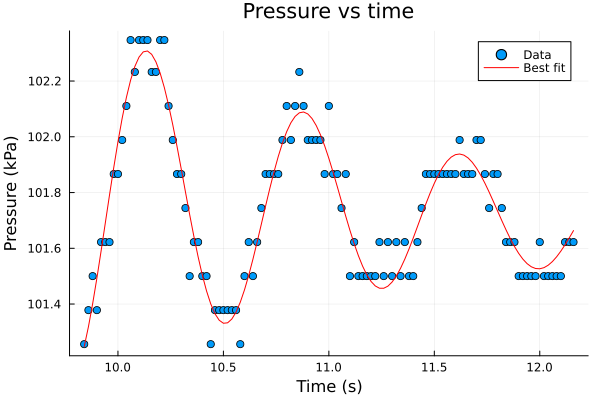

Parameters: [-225.45584634922272, 0.5960177444180237, 8.463580463117973, 13.111428840668825, 0.037627989519813214, 102.1545826185689]
Parameter errors (std dev): [127.19990765020816, 0.05335520158305105, 0.05139889894592667, 0.5415226246339255, 0.01188221370659689, 0.13132769960430962]


Frequency error (%): 2.8 ± 1.2


Experimental γ: 1.322 ± 0.033


γ error (%): 5.6 ± 2.4


In [7]:
t0 = [9.84,	9.86,	9.88,	9.9,	9.92,	9.94,	9.96,	9.98,	10,	10.02,	10.04,	10.06,	10.08,	10.1,	10.12,	10.14,	10.16,	10.18,	10.2,	10.22,	10.24,	10.26,	10.28,	10.3,	10.32,	10.34,	10.36,	10.38,	10.4,	10.42,	10.44,	10.46,	10.48,	10.5,	10.52,	10.54,	10.56,	10.58,	10.6,	10.62,	10.64,	10.66,	10.68,	10.7,	10.72,	10.74,	10.76,	10.78,	10.8,	10.82,	10.84,	10.86,	10.88,	10.9,	10.92,	10.94,	10.96,	10.98,	11,	11.02,	11.04,	11.06,	11.08,	11.1,	11.12,	11.14,	11.16,	11.18,	11.2,	11.22,	11.24,	11.26,	11.28,	11.3,	11.32,	11.34,	11.36,	11.38,	11.4,	11.42,	11.44,	11.46,	11.48,	11.5,	11.52,	11.54,	11.56,	11.58,	11.6,	11.62,	11.64,	11.66,	11.68,	11.7,	11.72,	11.74,	11.76,	11.78,	11.8,	11.82,	11.84,	11.86,	11.88,	11.9,	11.92,	11.94,	11.96,	11.98,	12,	12.02,	12.04,	12.06,	12.08,	12.1,	12.12,	12.14,	12.16,	12.18,	12.2,	12.22,	12.24,	12.26,	12.28,	12.3,	12.32,	12.34,	12.36,	12.38,	12.4,	12.42,	12.44,	12.46,	12.48,	12.5,	12.52,	12.54,	12.56,	12.58,	12.6,	12.62,	12.64,	12.66,	12.68,	12.7,	12.72,	12.74,	12.76,	12.78,	12.8,	12.82,	12.84,	12.86,	12.88,	12.9,	12.92,	12.94,	12.96,	12.98,	13,	13.02,	13.04,	13.06,	13.08,	13.1,	13.12,	13.14,	13.16,	13.18,	13.2,	13.22,	13.24,	13.26,	13.28,	13.3,	13.32,	13.34,	13.36,	13.38,	13.4,	13.42,	13.44,	13.46,	13.48,	13.5,	13.52,	13.54,	13.56,	13.58,	13.6,	13.62,	13.64,	13.66,	13.68,	13.7,	13.72,	13.74,	13.76,	13.78,	13.8,	13.82,	13.84,	13.86,	13.88,	13.9,	13.92,	13.94,	13.96,	13.98,	14,	14.02,	14.04,	14.06,	14.08,	14.1,	14.12,	14.14,	14.16,	14.18,	14.2,	14.22,	14.24,	14.26,	14.28,	14.3,	14.32,	14.34,	14.36,	14.38,	14.4,	14.42,	14.44,	14.46,	14.48,	14.5,	14.52,	14.54,	14.56,	14.58,	14.6,	14.62,	14.64,	14.66,	14.68,	14.7,	14.72,	14.74,	14.76,	14.78,	14.8,	14.82,	14.84,	14.86,	14.88,	14.9,	14.92,	14.94,	14.96,	14.98,	15,	15.02,	15.04,	15.06,	15.08,	15.1,	15.12,	15.14,	15.16,	15.18,	15.2,	15.22]
p0 = [101.256031036377,	101.378101348877,	101.500171661377,	101.378101348877,	101.622241973877,	101.622241973877,	101.622241973877,	101.866382598877,	101.866382598877,	101.988452911377,	102.110523223877,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.110523223877,	101.988452911377,	101.866382598877,	101.866382598877,	101.744312286377,	101.500171661377,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.256031036377,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.256031036377,	101.500171661377,	101.622241973877,	101.500171661377,	101.622241973877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	102.110523223877,	101.988452911377,	102.110523223877,	102.232593536377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	102.110523223877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.622241973877,	101.500171661377,	101.622241973877,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.622241973877,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.744312286377,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.622241973877,	101.866382598877,	101.744312286377,	101.866382598877,	101.622241973877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.622241973877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.622241973877,	101.744312286377,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.622241973877,	101.744312286377,	101.866382598877,	101.866382598877,	101.622241973877,	101.744312286377,	101.866382598877,	101.744312286377,	101.866382598877,	101.622241973877,	101.622241973877,	101.744312286377,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.622241973877,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.744312286377,	101.622241973877,	101.744312286377,	101.622241973877,	101.866382598877,	101.744312286377,	101.622241973877,	101.744312286377,	101.622241973877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.622241973877,	101.744312286377,	101.622241973877,	101.744312286377,	101.744312286377,	101.744312286377,	101.744312286377,	101.622241973877,	101.622241973877,	101.866382598877,	101.744312286377,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.866382598877,	101.744312286377,	101.744312286377,	101.622241973877,	101.866382598877,	101.744312286377,	101.622241973877,	101.744312286377,	101.622241973877];

t = t0[1:117]
p = p0[1:117];

ωe, γe = analysis(t, p, V0, P0, model)

push!(ωs[1], ωe)
push!(γs[1], γe);

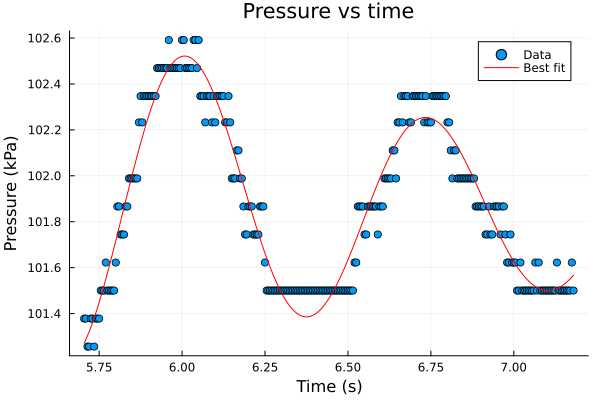

Parameters: [20.227196925408453, 0.5816281599378855, 8.642626865911467, -0.16859248751471803, 0.07735491984720969, 102.37408842934376]
Parameter errors (std dev): [4.7853415961433825, 0.03758884322395039, 0.03968085892204164, 0.24831421465208472, 0.013412856821175493, 0.08700640568420719]
Frequency error (%): 0.78 ± 0.97
Experimental γ: 1.378 ± 0.027
γ error (%): 1.6 ± 1.9


In [8]:
t1 = [5.705,	5.71,	5.715,	5.72,	5.725,	5.73,	5.735,	5.74,	5.745,	5.75,	5.755,	5.76,	5.765,	5.77,	5.775,	5.78,	5.785,	5.79,	5.795,	5.8,	5.805,	5.81,	5.815,	5.82,	5.825,	5.83,	5.835,	5.84,	5.845,	5.85,	5.855,	5.86,	5.865,	5.87,	5.875,	5.88,	5.885,	5.89,	5.895,	5.9,	5.905,	5.91,	5.915,	5.92,	5.925,	5.93,	5.935,	5.94,	5.945,	5.95,	5.955,	5.96,	5.965,	5.97,	5.975,	5.98,	5.985,	5.99,	5.995,	6,	6.005,	6.01,	6.015,	6.02,	6.025,	6.03,	6.035,	6.04,	6.045,	6.05,	6.055,	6.06,	6.065,	6.07,	6.075,	6.08,	6.085,	6.09,	6.095,	6.1,	6.105,	6.11,	6.115,	6.12,	6.125,	6.13,	6.135,	6.14,	6.145,	6.15,	6.155,	6.16,	6.165,	6.17,	6.175,	6.18,	6.185,	6.19,	6.195,	6.2,	6.205,	6.21,	6.215,	6.22,	6.225,	6.23,	6.235,	6.24,	6.245,	6.25,	6.255,	6.26,	6.265,	6.27,	6.275,	6.28,	6.285,	6.29,	6.295,	6.3,	6.305,	6.31,	6.315,	6.32,	6.325,	6.33,	6.335,	6.34,	6.345,	6.35,	6.355,	6.36,	6.365,	6.37,	6.375,	6.38,	6.385,	6.39,	6.395,	6.4,	6.405,	6.41,	6.415,	6.42,	6.425,	6.43,	6.435,	6.44,	6.445,	6.45,	6.455,	6.46,	6.465,	6.47,	6.475,	6.48,	6.485,	6.49,	6.495,	6.5,	6.505,	6.51,	6.515,	6.52,	6.525,	6.53,	6.535,	6.54,	6.545,	6.55,	6.555,	6.56,	6.565,	6.57,	6.575,	6.58,	6.585,	6.59,	6.595,	6.6,	6.605,	6.61,	6.615,	6.62,	6.625,	6.63,	6.635,	6.64,	6.645,	6.65,	6.655,	6.66,	6.665,	6.67,	6.675,	6.68,	6.685,	6.69,	6.695,	6.7,	6.705,	6.71,	6.715,	6.72,	6.725,	6.73,	6.735,	6.74,	6.745,	6.75,	6.755,	6.76,	6.765,	6.77,	6.775,	6.78,	6.785,	6.79,	6.795,	6.8,	6.805,	6.81,	6.815,	6.82,	6.825,	6.83,	6.835,	6.84,	6.845,	6.85,	6.855,	6.86,	6.865,	6.87,	6.875,	6.88,	6.885,	6.89,	6.895,	6.9,	6.905,	6.91,	6.915,	6.92,	6.925,	6.93,	6.935,	6.94,	6.945,	6.95,	6.955,	6.96,	6.965,	6.97,	6.975,	6.98,	6.985,	6.99,	6.995,	7,	7.005,	7.01,	7.015,	7.02,	7.025,	7.03,	7.035,	7.04,	7.045,	7.05,	7.055,	7.06,	7.065,	7.07,	7.075,	7.08,	7.085,	7.09,	7.095,	7.1,	7.105,	7.11,	7.115,	7.12,	7.125,	7.13,	7.135,	7.14,	7.145,	7.15,	7.155,	7.16,	7.165,	7.17,	7.175,	7.18]
p1 = [101.378101348877,	101.378101348877,	101.256031036377,	101.256031036377,	101.378101348877,	101.378101348877,	101.256031036377,	101.378101348877,	101.378101348877,	101.378101348877,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.232593536377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	101.988452911377,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	102.232593536377,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.110523223877,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.622241973877,	101.622241973877,	101.744312286377,	101.622241973877,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377];

t = t1
p = p1

ωe, γe = analysis(t, p, V0, P0, model)

push!(ωs[1], ωe)
push!(γs[1], γe);

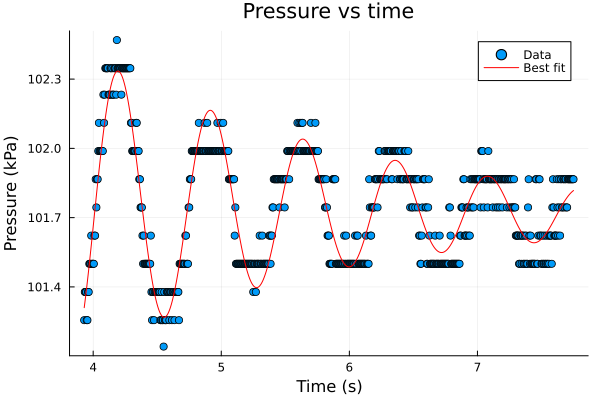

Parameters: [3.9094474553677667, 0.45691482482806, 8.707566818591209, -3.5778620700146897, 0.011917429995921044, 101.81022884119946]
Parameter errors (std dev): [0.3493573209401431, 0.017757601012503517, 0.016572863136368916, 0.08198862120783398, 0.003249062955167673, 0.019372086659719526]
Frequency error (%): 0.036 ± 0.51
Experimental γ: 1.399 ± 0.014
γ error (%): 0.072 ± 1.0


In [9]:
t2 = [3.93,	3.935,	3.94,	3.945,	3.95,	3.955,	3.96,	3.965,	3.97,	3.975,	3.98,	3.985,	3.99,	3.995,	4,	4.005,	4.01,	4.015,	4.02,	4.025,	4.03,	4.035,	4.04,	4.045,	4.05,	4.055,	4.06,	4.065,	4.07,	4.075,	4.08,	4.085,	4.09,	4.095,	4.1,	4.105,	4.11,	4.115,	4.12,	4.125,	4.13,	4.135,	4.14,	4.145,	4.15,	4.155,	4.16,	4.165,	4.17,	4.175,	4.18,	4.185,	4.19,	4.195,	4.2,	4.205,	4.21,	4.215,	4.22,	4.225,	4.23,	4.235,	4.24,	4.245,	4.25,	4.255,	4.26,	4.265,	4.27,	4.275,	4.28,	4.285,	4.29,	4.295,	4.3,	4.305,	4.31,	4.315,	4.32,	4.325,	4.33,	4.335,	4.34,	4.345,	4.35,	4.355,	4.36,	4.365,	4.37,	4.375,	4.38,	4.385,	4.39,	4.395,	4.4,	4.405,	4.41,	4.415,	4.42,	4.425,	4.43,	4.435,	4.44,	4.445,	4.45,	4.455,	4.46,	4.465,	4.47,	4.475,	4.48,	4.485,	4.49,	4.495,	4.5,	4.505,	4.51,	4.515,	4.52,	4.525,	4.53,	4.535,	4.54,	4.545,	4.55,	4.555,	4.56,	4.565,	4.57,	4.575,	4.58,	4.585,	4.59,	4.595,	4.6,	4.605,	4.61,	4.615,	4.62,	4.625,	4.63,	4.635,	4.64,	4.645,	4.65,	4.655,	4.66,	4.665,	4.67,	4.675,	4.68,	4.685,	4.69,	4.695,	4.7,	4.705,	4.71,	4.715,	4.72,	4.725,	4.73,	4.735,	4.74,	4.745,	4.75,	4.755,	4.76,	4.765,	4.77,	4.775,	4.78,	4.785,	4.79,	4.795,	4.8,	4.805,	4.81,	4.815,	4.82,	4.825,	4.83,	4.835,	4.84,	4.845,	4.85,	4.855,	4.86,	4.865,	4.87,	4.875,	4.88,	4.885,	4.89,	4.895,	4.9,	4.905,	4.91,	4.915,	4.92,	4.925,	4.93,	4.935,	4.94,	4.945,	4.95,	4.955,	4.96,	4.965,	4.97,	4.975,	4.98,	4.985,	4.99,	4.995,	5,	5.005,	5.01,	5.015,	5.02,	5.025,	5.03,	5.035,	5.04,	5.045,	5.05,	5.055,	5.06,	5.065,	5.07,	5.075,	5.08,	5.085,	5.09,	5.095,	5.1,	5.105,	5.11,	5.115,	5.12,	5.125,	5.13,	5.135,	5.14,	5.145,	5.15,	5.155,	5.16,	5.165,	5.17,	5.175,	5.18,	5.185,	5.19,	5.195,	5.2,	5.205,	5.21,	5.215,	5.22,	5.225,	5.23,	5.235,	5.24,	5.245,	5.25,	5.255,	5.26,	5.265,	5.27,	5.275,	5.28,	5.285,	5.29,	5.295,	5.3,	5.305,	5.31,	5.315,	5.32,	5.325,	5.33,	5.335,	5.34,	5.345,	5.35,	5.355,	5.36,	5.365,	5.37,	5.375,	5.38,	5.385,	5.39,	5.395,	5.4,	5.405,	5.41,	5.415,	5.42,	5.425,	5.43,	5.435,	5.44,	5.445,	5.45,	5.455,	5.46,	5.465,	5.47,	5.475,	5.48,	5.485,	5.49,	5.495,	5.5,	5.505,	5.51,	5.515,	5.52,	5.525,	5.53,	5.535,	5.54,	5.545,	5.55,	5.555,	5.56,	5.565,	5.57,	5.575,	5.58,	5.585,	5.59,	5.595,	5.6,	5.605,	5.61,	5.615,	5.62,	5.625,	5.63,	5.635,	5.64,	5.645,	5.65,	5.655,	5.66,	5.665,	5.67,	5.675,	5.68,	5.685,	5.69,	5.695,	5.7,	5.705,	5.71,	5.715,	5.72,	5.725,	5.73,	5.735,	5.74,	5.745,	5.75,	5.755,	5.76,	5.765,	5.77,	5.775,	5.78,	5.785,	5.79,	5.795,	5.8,	5.805,	5.81,	5.815,	5.82,	5.825,	5.83,	5.835,	5.84,	5.845,	5.85,	5.855,	5.86,	5.865,	5.87,	5.875,	5.88,	5.885,	5.89,	5.895,	5.9,	5.905,	5.91,	5.915,	5.92,	5.925,	5.93,	5.935,	5.94,	5.945,	5.95,	5.955,	5.96,	5.965,	5.97,	5.975,	5.98,	5.985,	5.99,	5.995,	6,	6.005,	6.01,	6.015,	6.02,	6.025,	6.03,	6.035,	6.04,	6.045,	6.05,	6.055,	6.06,	6.065,	6.07,	6.075,	6.08,	6.085,	6.09,	6.095,	6.1,	6.105,	6.11,	6.115,	6.12,	6.125,	6.13,	6.135,	6.14,	6.145,	6.15,	6.155,	6.16,	6.165,	6.17,	6.175,	6.18,	6.185,	6.19,	6.195,	6.2,	6.205,	6.21,	6.215,	6.22,	6.225,	6.23,	6.235,	6.24,	6.245,	6.25,	6.255,	6.26,	6.265,	6.27,	6.275,	6.28,	6.285,	6.29,	6.295,	6.3,	6.305,	6.31,	6.315,	6.32,	6.325,	6.33,	6.335,	6.34,	6.345,	6.35,	6.355,	6.36,	6.365,	6.37,	6.375,	6.38,	6.385,	6.39,	6.395,	6.4,	6.405,	6.41,	6.415,	6.42,	6.425,	6.43,	6.435,	6.44,	6.445,	6.45,	6.455,	6.46,	6.465,	6.47,	6.475,	6.48,	6.485,	6.49,	6.495,	6.5,	6.505,	6.51,	6.515,	6.52,	6.525,	6.53,	6.535,	6.54,	6.545,	6.55,	6.555,	6.56,	6.565,	6.57,	6.575,	6.58,	6.585,	6.59,	6.595,	6.6,	6.605,	6.61,	6.615,	6.62,	6.625,	6.63,	6.635,	6.64,	6.645,	6.65,	6.655,	6.66,	6.665,	6.67,	6.675,	6.68,	6.685,	6.69,	6.695,	6.7,	6.705,	6.71,	6.715,	6.72,	6.725,	6.73,	6.735,	6.74,	6.745,	6.75,	6.755,	6.76,	6.765,	6.77,	6.775,	6.78,	6.785,	6.79,	6.795,	6.8,	6.805,	6.81,	6.815,	6.82,	6.825,	6.83,	6.835,	6.84,	6.845,	6.85,	6.855,	6.86,	6.865,	6.87,	6.875,	6.88,	6.885,	6.89,	6.895,	6.9,	6.905,	6.91,	6.915,	6.92,	6.925,	6.93,	6.935,	6.94,	6.945,	6.95,	6.955,	6.96,	6.965,	6.97,	6.975,	6.98,	6.985,	6.99,	6.995,	7,	7.005,	7.01,	7.015,	7.02,	7.025,	7.03,	7.035,	7.04,	7.045,	7.05,	7.055,	7.06,	7.065,	7.07,	7.075,	7.08,	7.085,	7.09,	7.095,	7.1,	7.105,	7.11,	7.115,	7.12,	7.125,	7.13,	7.135,	7.14,	7.145,	7.15,	7.155,	7.16,	7.165,	7.17,	7.175,	7.18,	7.185,	7.19,	7.195,	7.2,	7.205,	7.21,	7.215,	7.22,	7.225,	7.23,	7.235,	7.24,	7.245,	7.25,	7.255,	7.26,	7.265,	7.27,	7.275,	7.28,	7.285,	7.29,	7.295,	7.3,	7.305,	7.31,	7.315,	7.32,	7.325,	7.33,	7.335,	7.34,	7.345,	7.35,	7.355,	7.36,	7.365,	7.37,	7.375,	7.38,	7.385,	7.39,	7.395,	7.4,	7.405,	7.41,	7.415,	7.42,	7.425,	7.43,	7.435,	7.44,	7.445,	7.45,	7.455,	7.46,	7.465,	7.47,	7.475,	7.48,	7.485,	7.49,	7.495,	7.5,	7.505,	7.51,	7.515,	7.52,	7.525,	7.53,	7.535,	7.54,	7.545,	7.55,	7.555,	7.56,	7.565,	7.57,	7.575,	7.58,	7.585,	7.59,	7.595,	7.6,	7.605,	7.61,	7.615,	7.62,	7.625,	7.63,	7.635,	7.64,	7.645,	7.65,	7.655,	7.66,	7.665,	7.67,	7.675,	7.68,	7.685,	7.69,	7.695,	7.7,	7.705,	7.71,	7.715,	7.72,	7.725,	7.73,	7.735,	7.74,	7.745,	7.75]
p2 = [101.256031036377,	101.378101348877,	101.378101348877,	101.378101348877,	101.256031036377,	101.256031036377,	101.378101348877,	101.378101348877,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.232593536377,	102.110523223877,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.110523223877,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.622241973877,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.378101348877,	101.256031036377,	101.378101348877,	101.378101348877,	101.256031036377,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.256031036377,	101.256031036377,	101.378101348877,	101.256031036377,	101.256031036377,	101.141590118408,	101.378101348877,	101.256031036377,	101.256031036377,	101.256031036377,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.256031036377,	101.378101348877,	101.378101348877,	101.378101348877,	101.256031036377,	101.378101348877,	101.378101348877,	101.378101348877,	101.256031036377,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.256031036377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.622241973877,	101.744312286377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.378101348877,	101.500171661377,	101.500171661377,	101.500171661377,	101.378101348877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.500171661377,	101.622241973877,	101.622241973877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	102.110523223877,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.744312286377,	101.622241973877,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.866382598877,	101.744312286377,	101.622241973877,	101.622241973877,	101.744312286377,	101.744312286377,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.866382598877,	101.988452911377,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.500171661377,	101.500171661377,	101.744312286377,	101.866382598877,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.744312286377,	101.744312286377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.622241973877,	101.622241973877,	101.622241973877,	101.744312286377,	101.622241973877,	101.744312286377,	101.744312286377,	101.622241973877,	101.622241973877,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.500171661377,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.744312286377,	101.866382598877,	101.622241973877,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.866382598877,	101.866382598877,	101.500171661377,	101.500171661377,	101.622241973877,	101.866382598877,	101.866382598877,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.622241973877,	101.622241973877,	101.622241973877,	101.500171661377,	101.744312286377,	101.866382598877,	101.744312286377,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.866382598877,	101.744312286377,	101.622241973877,	101.866382598877,	101.744312286377,	101.622241973877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877];

t = t2
p = p2

ωe, γe = analysis(t, p, V0, P0, model)

push!(ωs[1], ωe)
push!(γs[1], γe);

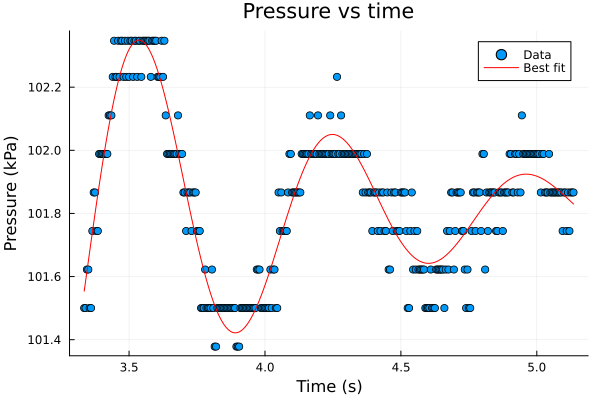

Parameters: [31.984728870763185, 1.141470802817075, 8.832693648896218, 1.6271991917708157, -0.017669678338706474, 101.72633563997681]
Parameter errors (std dev): [7.298294728866291, 0.059280038064914074, 0.048052121200301494, 0.1794934585957215, 0.010156112864643869, 0.04383665875943503]
Frequency error (%): 1.4 ± 1.2
Experimental γ: 1.439 ± 0.033
γ error (%): 2.8 ± 2.3


In [10]:
t3 = [3.335,	3.34,	3.345,	3.35,	3.355,	3.36,	3.365,	3.37,	3.375,	3.38,	3.385,	3.39,	3.395,	3.4,	3.405,	3.41,	3.415,	3.42,	3.425,	3.43,	3.435,	3.44,	3.445,	3.45,	3.455,	3.46,	3.465,	3.47,	3.475,	3.48,	3.485,	3.49,	3.495,	3.5,	3.505,	3.51,	3.515,	3.52,	3.525,	3.53,	3.535,	3.54,	3.545,	3.55,	3.555,	3.56,	3.565,	3.57,	3.575,	3.58,	3.585,	3.59,	3.595,	3.6,	3.605,	3.61,	3.615,	3.62,	3.625,	3.63,	3.635,	3.64,	3.645,	3.65,	3.655,	3.66,	3.665,	3.67,	3.675,	3.68,	3.685,	3.69,	3.695,	3.7,	3.705,	3.71,	3.715,	3.72,	3.725,	3.73,	3.735,	3.74,	3.745,	3.75,	3.755,	3.76,	3.765,	3.77,	3.775,	3.78,	3.785,	3.79,	3.795,	3.8,	3.805,	3.81,	3.815,	3.82,	3.825,	3.83,	3.835,	3.84,	3.845,	3.85,	3.855,	3.86,	3.865,	3.87,	3.875,	3.88,	3.885,	3.89,	3.895,	3.9,	3.905,	3.91,	3.915,	3.92,	3.925,	3.93,	3.935,	3.94,	3.945,	3.95,	3.955,	3.96,	3.965,	3.97,	3.975,	3.98,	3.985,	3.99,	3.995,	4,	4.005,	4.01,	4.015,	4.02,	4.025,	4.03,	4.035,	4.04,	4.045,	4.05,	4.055,	4.06,	4.065,	4.07,	4.075,	4.08,	4.085,	4.09,	4.095,	4.1,	4.105,	4.11,	4.115,	4.12,	4.125,	4.13,	4.135,	4.14,	4.145,	4.15,	4.155,	4.16,	4.165,	4.17,	4.175,	4.18,	4.185,	4.19,	4.195,	4.2,	4.205,	4.21,	4.215,	4.22,	4.225,	4.23,	4.235,	4.24,	4.245,	4.25,	4.255,	4.26,	4.265,	4.27,	4.275,	4.28,	4.285,	4.29,	4.295,	4.3,	4.305,	4.31,	4.315,	4.32,	4.325,	4.33,	4.335,	4.34,	4.345,	4.35,	4.355,	4.36,	4.365,	4.37,	4.375,	4.38,	4.385,	4.39,	4.395,	4.4,	4.405,	4.41,	4.415,	4.42,	4.425,	4.43,	4.435,	4.44,	4.445,	4.45,	4.455,	4.46,	4.465,	4.47,	4.475,	4.48,	4.485,	4.49,	4.495,	4.5,	4.505,	4.51,	4.515,	4.52,	4.525,	4.53,	4.535,	4.54,	4.545,	4.55,	4.555,	4.56,	4.565,	4.57,	4.575,	4.58,	4.585,	4.59,	4.595,	4.6,	4.605,	4.61,	4.615,	4.62,	4.625,	4.63,	4.635,	4.64,	4.645,	4.65,	4.655,	4.66,	4.665,	4.67,	4.675,	4.68,	4.685,	4.69,	4.695,	4.7,	4.705,	4.71,	4.715,	4.72,	4.725,	4.73,	4.735,	4.74,	4.745,	4.75,	4.755,	4.76,	4.765,	4.77,	4.775,	4.78,	4.785,	4.79,	4.795,	4.8,	4.805,	4.81,	4.815,	4.82,	4.825,	4.83,	4.835,	4.84,	4.845,	4.85,	4.855,	4.86,	4.865,	4.87,	4.875,	4.88,	4.885,	4.89,	4.895,	4.9,	4.905,	4.91,	4.915,	4.92,	4.925,	4.93,	4.935,	4.94,	4.945,	4.95,	4.955,	4.96,	4.965,	4.97,	4.975,	4.98,	4.985,	4.99,	4.995,	5,	5.005,	5.01,	5.015,	5.02,	5.025,	5.03,	5.035,	5.04,	5.045,	5.05,	5.055,	5.06,	5.065,	5.07,	5.075,	5.08,	5.085,	5.09,	5.095,	5.1,	5.105,	5.11,	5.115,	5.12,	5.125,	5.13,	5.135]
p3 = [101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	102.110523223877,	102.232593536377,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.378101348877,	101.378101348877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.378101348877,	101.378101348877,	101.378101348877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.232593536377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.988452911377,	101.866382598877,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.622241973877,	101.622241973877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.500171661377,	101.500171661377,	101.744312286377,	101.866382598877,	101.622241973877,	101.744312286377,	101.622241973877,	101.744312286377,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.622241973877,	101.500171661377,	101.622241973877,	101.744312286377,	101.622241973877,	101.744312286377,	101.866382598877,	101.866382598877,	101.622241973877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.622241973877,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.988452911377,	101.988452911377,	101.622241973877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.866382598877,	101.988452911377,	101.866382598877,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877];

t = t3
p = p3

ωe, γe = analysis(t, p, V0, P0, model)

push!(ωs[1], ωe)
push!(γs[1], γe);

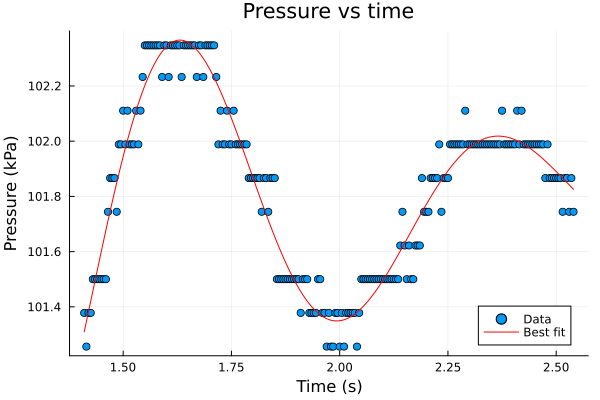

Parameters: [5.725783442919779, 1.3307209703999439, 8.578405411402738, 0.006078082421868421, -0.07519199384724422, 101.5965283516659]
Parameter errors (std dev): [0.9247190515564525, 0.08757604901502991, 0.062409922772422154, 0.10945560362129417, 0.025681901532094268, 0.052809094233755]
Frequency error (%): 1.5 ± 1.5
Experimental γ: 1.358 ± 0.041
γ error (%): 3.0 ± 2.9


In [11]:
t4 = [1.41,	1.415,	1.42,	1.425,	1.43,	1.435,	1.44,	1.445,	1.45,	1.455,	1.46,	1.465,	1.47,	1.475,	1.48,	1.485,	1.49,	1.495,	1.5,	1.505,	1.51,	1.515,	1.52,	1.525,	1.53,	1.535,	1.54,	1.545,	1.55,	1.555,	1.56,	1.565,	1.57,	1.575,	1.58,	1.585,	1.59,	1.595,	1.6,	1.605,	1.61,	1.615,	1.62,	1.625,	1.63,	1.635,	1.64,	1.645,	1.65,	1.655,	1.66,	1.665,	1.67,	1.675,	1.68,	1.685,	1.69,	1.695,	1.7,	1.705,	1.71,	1.715,	1.72,	1.725,	1.73,	1.735,	1.74,	1.745,	1.75,	1.755,	1.76,	1.765,	1.77,	1.775,	1.78,	1.785,	1.79,	1.795,	1.8,	1.805,	1.81,	1.815,	1.82,	1.825,	1.83,	1.835,	1.84,	1.845,	1.85,	1.855,	1.86,	1.865,	1.87,	1.875,	1.88,	1.885,	1.89,	1.895,	1.9,	1.905,	1.91,	1.915,	1.92,	1.925,	1.93,	1.935,	1.94,	1.945,	1.95,	1.955,	1.96,	1.965,	1.97,	1.975,	1.98,	1.985,	1.99,	1.995,	2,	2.005,	2.01,	2.015,	2.02,	2.025,	2.03,	2.035,	2.04,	2.045,	2.05,	2.055,	2.06,	2.065,	2.07,	2.075,	2.08,	2.085,	2.09,	2.095,	2.1,	2.105,	2.11,	2.115,	2.12,	2.125,	2.13,	2.135,	2.14,	2.145,	2.15,	2.155,	2.16,	2.165,	2.17,	2.175,	2.18,	2.185,	2.19,	2.195,	2.2,	2.205,	2.21,	2.215,	2.22,	2.225,	2.23,	2.235,	2.24,	2.245,	2.25,	2.255,	2.26,	2.265,	2.27,	2.275,	2.28,	2.285,	2.29,	2.295,	2.3,	2.305,	2.31,	2.315,	2.32,	2.325,	2.33,	2.335,	2.34,	2.345,	2.35,	2.355,	2.36,	2.365,	2.37,	2.375,	2.38,	2.385,	2.39,	2.395,	2.4,	2.405,	2.41,	2.415,	2.42,	2.425,	2.43,	2.435,	2.44,	2.445,	2.45,	2.455,	2.46,	2.465,	2.47,	2.475,	2.48,	2.485,	2.49,	2.495,	2.5,	2.505,	2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54]
p4 = [101.378101348877,	101.256031036377,	101.378101348877,	101.378101348877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	102.110523223877,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.378101348877,	101.500171661377,	101.500171661377,	101.500171661377,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.500171661377,	101.500171661377,	101.378101348877,	101.378101348877,	101.256031036377,	101.378101348877,	101.256031036377,	101.256031036377,	101.378101348877,	101.378101348877,	101.256031036377,	101.378101348877,	101.256031036377,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.378101348877,	101.256031036377,	101.378101348877,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.500171661377,	101.622241973877,	101.744312286377,	101.622241973877,	101.500171661377,	101.622241973877,	101.500171661377,	101.500171661377,	101.622241973877,	101.622241973877,	101.622241973877,	101.866382598877,	101.744312286377,	101.744312286377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.744312286377,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.866382598877,	101.744312286377,	101.866382598877,	101.744312286377];

t = t4
p = p4

ωe, γe = analysis(t, p, V0, P0, model)

push!(ωs[1], ωe)
push!(γs[1], γe);

In [12]:
#new V and P
const V1 = 0.0050238 ± 0.000035 #m^3
const P1 = 101500 ± 200 #Pa

push!(Vs, V1)
push!(Ps, P1)
push!(ωs, [])
push!(γs, []);

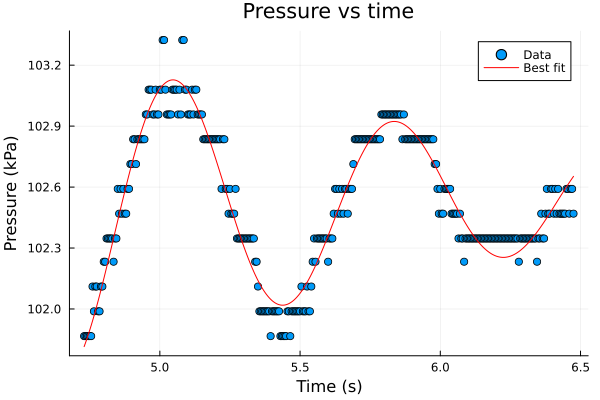

Parameters: [14.97505126769644, 0.6259800915613872, 7.9723646947705165, -1.0320946706218248, -0.053720743091813544, 102.22221273932742]
Parameter errors (std dev): [2.6179673080673447, 0.032644341629629224, 0.030889127880196134, 0.16549718890172632, 0.010619088302110962, 0.06009858240698398]
Frequency error (%): 3.62 ± 0.82
Experimental γ: 1.3 ± 0.022
γ error (%): 7.1 ± 1.6


In [13]:
t5 = [4.73,	4.735,	4.74,	4.745,	4.75,	4.755,	4.76,	4.765,	4.77,	4.775,	4.78,	4.785,	4.79,	4.795,	4.8,	4.805,	4.81,	4.815,	4.82,	4.825,	4.83,	4.835,	4.84,	4.845,	4.85,	4.855,	4.86,	4.865,	4.87,	4.875,	4.88,	4.885,	4.89,	4.895,	4.9,	4.905,	4.91,	4.915,	4.92,	4.925,	4.93,	4.935,	4.94,	4.945,	4.95,	4.955,	4.96,	4.965,	4.97,	4.975,	4.98,	4.985,	4.99,	4.995,	5,	5.005,	5.01,	5.015,	5.02,	5.025,	5.03,	5.035,	5.04,	5.045,	5.05,	5.055,	5.06,	5.065,	5.07,	5.075,	5.08,	5.085,	5.09,	5.095,	5.1,	5.105,	5.11,	5.115,	5.12,	5.125,	5.13,	5.135,	5.14,	5.145,	5.15,	5.155,	5.16,	5.165,	5.17,	5.175,	5.18,	5.185,	5.19,	5.195,	5.2,	5.205,	5.21,	5.215,	5.22,	5.225,	5.23,	5.235,	5.24,	5.245,	5.25,	5.255,	5.26,	5.265,	5.27,	5.275,	5.28,	5.285,	5.29,	5.295,	5.3,	5.305,	5.31,	5.315,	5.32,	5.325,	5.33,	5.335,	5.34,	5.345,	5.35,	5.355,	5.36,	5.365,	5.37,	5.375,	5.38,	5.385,	5.39,	5.395,	5.4,	5.405,	5.41,	5.415,	5.42,	5.425,	5.43,	5.435,	5.44,	5.445,	5.45,	5.455,	5.46,	5.465,	5.47,	5.475,	5.48,	5.485,	5.49,	5.495,	5.5,	5.505,	5.51,	5.515,	5.52,	5.525,	5.53,	5.535,	5.54,	5.545,	5.55,	5.555,	5.56,	5.565,	5.57,	5.575,	5.58,	5.585,	5.59,	5.595,	5.6,	5.605,	5.61,	5.615,	5.62,	5.625,	5.63,	5.635,	5.64,	5.645,	5.65,	5.655,	5.66,	5.665,	5.67,	5.675,	5.68,	5.685,	5.69,	5.695,	5.7,	5.705,	5.71,	5.715,	5.72,	5.725,	5.73,	5.735,	5.74,	5.745,	5.75,	5.755,	5.76,	5.765,	5.77,	5.775,	5.78,	5.785,	5.79,	5.795,	5.8,	5.805,	5.81,	5.815,	5.82,	5.825,	5.83,	5.835,	5.84,	5.845,	5.85,	5.855,	5.86,	5.865,	5.87,	5.875,	5.88,	5.885,	5.89,	5.895,	5.9,	5.905,	5.91,	5.915,	5.92,	5.925,	5.93,	5.935,	5.94,	5.945,	5.95,	5.955,	5.96,	5.965,	5.97,	5.975,	5.98,	5.985,	5.99,	5.995,	6,	6.005,	6.01,	6.015,	6.02,	6.025,	6.03,	6.035,	6.04,	6.045,	6.05,	6.055,	6.06,	6.065,	6.07,	6.075,	6.08,	6.085,	6.09,	6.095,	6.1,	6.105,	6.11,	6.115,	6.12,	6.125,	6.13,	6.135,	6.14,	6.145,	6.15,	6.155,	6.16,	6.165,	6.17,	6.175,	6.18,	6.185,	6.19,	6.195,	6.2,	6.205,	6.21,	6.215,	6.22,	6.225,	6.23,	6.235,	6.24,	6.245,	6.25,	6.255,	6.26,	6.265,	6.27,	6.275,	6.28,	6.285,	6.29,	6.295,	6.3,	6.305,	6.31,	6.315,	6.32,	6.325,	6.33,	6.335,	6.34,	6.345,	6.35,	6.355,	6.36,	6.365,	6.37,	6.375,	6.38,	6.385,	6.39,	6.395,	6.4,	6.405,	6.41,	6.415,	6.42,	6.425,	6.43,	6.435,	6.44,	6.445,	6.45,	6.455,	6.46,	6.465,	6.47,	6.475]
p5 = [101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	102.110523223877,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.323596954345,	103.323596954345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.323596954345,	103.323596954345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.866382598877,	101.988452911377,	101.988452911377,	101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	102.110523223877,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845];

t = t5
p = p5

ωe, γe = analysis(t, p, V1, P1, model, predictions=[1, 0.1, sqrt(1.4*P1*(A^2)/(m*V1)).val, -π/2, 0.005, P1.val/1000])

push!(ωs[2], ωe)
push!(γs[2], γe);

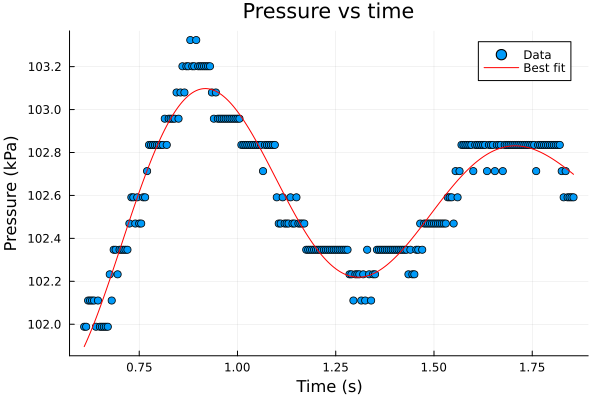

Parameters: [1.453202693871252, 1.0657908306608008, 7.992377095046714, 0.3950152957543468, -0.052033294195345164, 102.50769397398918]
Parameter errors (std dev): [0.11259023595941364, 0.0708698483590236, 0.07839765729399867, 0.08443466351853576, 0.02301544726267671, 0.03044104222269006]
Frequency error (%): 3.4 ± 1.9
Experimental γ: 1.307 ± 0.052
γ error (%): 6.6 ± 3.7


In [14]:
t6 = [0.61,	0.615,	0.62,	0.625,	0.63,	0.635,	0.64,	0.645,	0.65,	0.655,	0.66,	0.665,	0.67,	0.675,	0.68,	0.685,	0.69,	0.695,	0.7,	0.705,	0.71,	0.715,	0.72,	0.725,	0.73,	0.735,	0.74,	0.745,	0.75,	0.755,	0.76,	0.765,	0.77,	0.775,	0.78,	0.785,	0.79,	0.795,	0.8,	0.805,	0.81,	0.815,	0.82,	0.825,	0.83,	0.835,	0.84,	0.845,	0.85,	0.855,	0.86,	0.865,	0.87,	0.875,	0.88,	0.885,	0.89,	0.895,	0.9,	0.905,	0.91,	0.915,	0.92,	0.925,	0.93,	0.935,	0.94,	0.945,	0.95,	0.955,	0.96,	0.965,	0.97,	0.975,	0.98,	0.985,	0.99,	0.995,	1,	1.005,	1.01,	1.015,	1.02,	1.025,	1.03,	1.035,	1.04,	1.045,	1.05,	1.055,	1.06,	1.065,	1.07,	1.075,	1.08,	1.085,	1.09,	1.095,	1.1,	1.105,	1.11,	1.115,	1.12,	1.125,	1.13,	1.135,	1.14,	1.145,	1.15,	1.155,	1.16,	1.165,	1.17,	1.175,	1.18,	1.185,	1.19,	1.195,	1.2,	1.205,	1.21,	1.215,	1.22,	1.225,	1.23,	1.235,	1.24,	1.245,	1.25,	1.255,	1.26,	1.265,	1.27,	1.275,	1.28,	1.285,	1.29,	1.295,	1.3,	1.305,	1.31,	1.315,	1.32,	1.325,	1.33,	1.335,	1.34,	1.345,	1.35,	1.355,	1.36,	1.365,	1.37,	1.375,	1.38,	1.385,	1.39,	1.395,	1.4,	1.405,	1.41,	1.415,	1.42,	1.425,	1.43,	1.435,	1.44,	1.445,	1.45,	1.455,	1.46,	1.465,	1.47,	1.475,	1.48,	1.485,	1.49,	1.495,	1.5,	1.505,	1.51,	1.515,	1.52,	1.525,	1.53,	1.535,	1.54,	1.545,	1.55,	1.555,	1.56,	1.565,	1.57,	1.575,	1.58,	1.585,	1.59,	1.595,	1.6,	1.605,	1.61,	1.615,	1.62,	1.625,	1.63,	1.635,	1.64,	1.645,	1.65,	1.655,	1.66,	1.665,	1.67,	1.675,	1.68,	1.685,	1.69,	1.695,	1.7,	1.705,	1.71,	1.715,	1.72,	1.725,	1.73,	1.735,	1.74,	1.745,	1.75,	1.755,	1.76,	1.765,	1.77,	1.775,	1.78,	1.785,	1.79,	1.795,	1.8,	1.805,	1.81,	1.815,	1.82,	1.825,	1.83,	1.835,	1.84,	1.845,	1.85,	1.855]
p6 = [101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	102.110523223877,	102.110523223877,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.232593536377,	102.110523223877,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.201526641845,	103.079456329345,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.110523223877,	102.232593536377,	102.232593536377,	102.232593536377,	102.110523223877,	102.232593536377,	102.110523223877,	102.347034454345,	102.232593536377,	102.110523223877,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.713245391845,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345]

t = t6
p = p6

ωe, γe = analysis(t, p, V1, P1, model)#, predictions=[1, 0.1, sqrt(1.4*P1*(A^2)/(m*V1)).val, -π/2, 0.005, P1.val/1000])

push!(ωs[2], ωe)
push!(γs[2], γe);

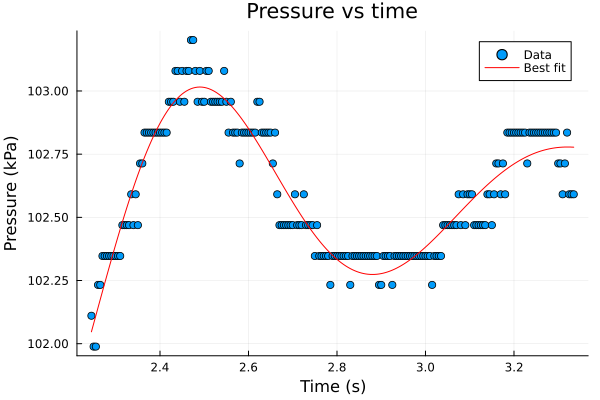

Parameters: [31.794980100022606, 1.631051006619329, 7.719515250909928, 1.0345426570775167, -0.19476331374683234, 101.99037524133465]
Parameter errors (std dev): [11.912126772386681, 0.1367967129079376, 0.18088344690679037, 0.46375842784655363, 0.05553201071403573, 0.1608756200903693]
Frequency error (%): 6.7 ± 4.4
Experimental γ: 1.22 ± 0.11
γ error (%): 12.9 ± 8.2


In [15]:
t7 = [2.245,	2.25,	2.255,	2.26,	2.265,	2.27,	2.275,	2.28,	2.285,	2.29,	2.295,	2.3,	2.305,	2.31,	2.315,	2.32,	2.325,	2.33,	2.335,	2.34,	2.345,	2.35,	2.355,	2.36,	2.365,	2.37,	2.375,	2.38,	2.385,	2.39,	2.395,	2.4,	2.405,	2.41,	2.415,	2.42,	2.425,	2.43,	2.435,	2.44,	2.445,	2.45,	2.455,	2.46,	2.465,	2.47,	2.475,	2.48,	2.485,	2.49,	2.495,	2.5,	2.505,	2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54,	2.545,	2.55,	2.555,	2.56,	2.565,	2.57,	2.575,	2.58,	2.585,	2.59,	2.595,	2.6,	2.605,	2.61,	2.615,	2.62,	2.625,	2.63,	2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965,	2.97,	2.975,	2.98,	2.985,	2.99,	2.995,	3,	3.005,	3.01,	3.015,	3.02,	3.025,	3.03,	3.035,	3.04,	3.045,	3.05,	3.055,	3.06,	3.065,	3.07,	3.075,	3.08,	3.085,	3.09,	3.095,	3.1,	3.105,	3.11,	3.115,	3.12,	3.125,	3.13,	3.135,	3.14,	3.145,	3.15,	3.155,	3.16,	3.165,	3.17,	3.175,	3.18,	3.185,	3.19,	3.195,	3.2,	3.205,	3.21,	3.215,	3.22,	3.225,	3.23,	3.235,	3.24,	3.245,	3.25,	3.255,	3.26,	3.265,	3.27,	3.275,	3.28,	3.285,	3.29,	3.295,	3.3,	3.305,	3.31,	3.315,	3.32,	3.325,	3.33,	3.335]
p7 = [102.110523223877,	101.988452911377,	101.988452911377,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	103.201526641845,	103.201526641845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.713245391845,	102.713245391845,	102.591175079345,	102.713245391845,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.591175079345,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345];

t = t7
p = p7

ωe, γe = analysis(t, p, V1, P1, model)#, predictions=[1, 0.1, sqrt(1.4*P1*(A^2)/(m*V1)).val, -π/2, 0.005, P1.val/1000])

push!(ωs[2], ωe)
push!(γs[2], γe);

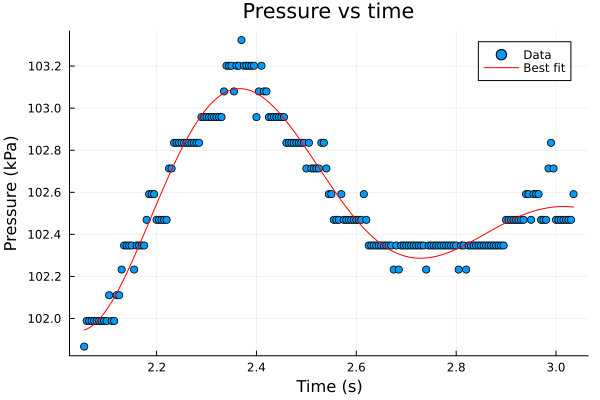

Parameters: [-39.29803970135781, 1.8806566270122196, 9.374567715478879, -5.190110098389766, 0.3697471110689687, 103.52740464209653]
Parameter errors (std dev): [8.834077851584162, 0.09846682367165024, 0.1721761965002502, 0.4158268666112376, 0.04095563837715202, 0.10776993982831118]
Frequency error (%): 13.3 ± 4.2
Experimental γ: 1.8 ± 0.13
γ error (%): 28.4 ± 9.5


In [16]:
t8 = [2.055,	2.06,	2.065,	2.07,	2.075,	2.08,	2.085,	2.09,	2.095,	2.1,	2.105,	2.11,	2.115,	2.12,	2.125,	2.13,	2.135,	2.14,	2.145,	2.15,	2.155,	2.16,	2.165,	2.17,	2.175,	2.18,	2.185,	2.19,	2.195,	2.2,	2.205,	2.21,	2.215,	2.22,	2.225,	2.23,	2.235,	2.24,	2.245,	2.25,	2.255,	2.26,	2.265,	2.27,	2.275,	2.28,	2.285,	2.29,	2.295,	2.3,	2.305,	2.31,	2.315,	2.32,	2.325,	2.33,	2.335,	2.34,	2.345,	2.35,	2.355,	2.36,	2.365,	2.37,	2.375,	2.38,	2.385,	2.39,	2.395,	2.4,	2.405,	2.41,	2.415,	2.42,	2.425,	2.43,	2.435,	2.44,	2.445,	2.45,	2.455,	2.46,	2.465,	2.47,	2.475,	2.48,	2.485,	2.49,	2.495,	2.5,	2.505,	2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54,	2.545,	2.55,	2.555,	2.56,	2.565,	2.57,	2.575,	2.58,	2.585,	2.59,	2.595,	2.6,	2.605,	2.61,	2.615,	2.62,	2.625,	2.63,	2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965,	2.97,	2.975,	2.98,	2.985,	2.99,	2.995,	3,	3.005,	3.01,	3.015,	3.02,	3.025,	3.03,	3.035]
p8 = [101.866382598877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	102.957386016845,	103.079456329345,	103.201526641845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.713245391845,	102.835315704345,	102.713245391845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345];

t = t8
p = p8

ωe, γe = analysis(t, p, V1, P1, model, predictions=[-1, 0.1, sqrt(1.4*P1*(A^2)/(m*V1)).val, -π/2, 0.005, P1.val/1000])

push!(ωs[2], ωe)
push!(γs[2], γe);

In [17]:
#new V and P
const V2 = (5523.8 ± 40)/1e6
const P2 = 101900 ± 200

push!(Vs, V2)
push!(Ps, P2)
push!(ωs, [])
push!(γs, []);

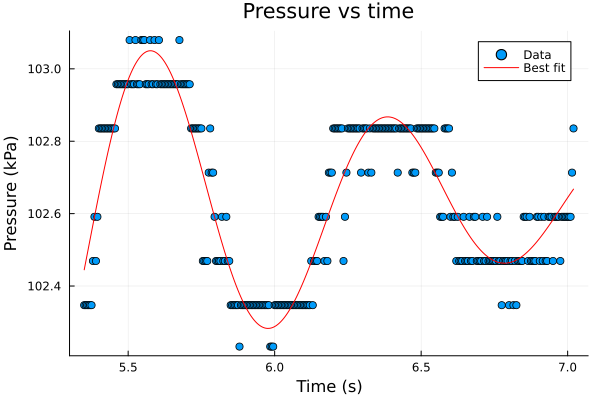

Parameters: [-33.84910593170438, 0.773775205982607, 7.77272330765705, -7.302421216378067, -0.033299100967264725, 102.4134940187487]
Parameter errors (std dev): [11.095843273288308, 0.055158009605219153, 0.046461186463225286, 0.27222212153622405, 0.010470009614671531, 0.06546456181520617]
Frequency error (%): 1.7 ± 1.2
Experimental γ: 1.354 ± 0.034
γ error (%): 3.3 ± 2.4


In [18]:
t9 = [5.35,	5.355,	5.36,	5.365,	5.37,	5.375,	5.38,	5.385,	5.39,	5.395,	5.4,	5.405,	5.41,	5.415,	5.42,	5.425,	5.43,	5.435,	5.44,	5.445,	5.45,	5.455,	5.46,	5.465,	5.47,	5.475,	5.48,	5.485,	5.49,	5.495,	5.5,	5.505,	5.51,	5.515,	5.52,	5.525,	5.53,	5.535,	5.54,	5.545,	5.55,	5.555,	5.56,	5.565,	5.57,	5.575,	5.58,	5.585,	5.59,	5.595,	5.6,	5.605,	5.61,	5.615,	5.62,	5.625,	5.63,	5.635,	5.64,	5.645,	5.65,	5.655,	5.66,	5.665,	5.67,	5.675,	5.68,	5.685,	5.69,	5.695,	5.7,	5.705,	5.71,	5.715,	5.72,	5.725,	5.73,	5.735,	5.74,	5.745,	5.75,	5.755,	5.76,	5.765,	5.77,	5.775,	5.78,	5.785,	5.79,	5.795,	5.8,	5.805,	5.81,	5.815,	5.82,	5.825,	5.83,	5.835,	5.84,	5.845,	5.85,	5.855,	5.86,	5.865,	5.87,	5.875,	5.88,	5.885,	5.89,	5.895,	5.9,	5.905,	5.91,	5.915,	5.92,	5.925,	5.93,	5.935,	5.94,	5.945,	5.95,	5.955,	5.96,	5.965,	5.97,	5.975,	5.98,	5.985,	5.99,	5.995,	6,	6.005,	6.01,	6.015,	6.02,	6.025,	6.03,	6.035,	6.04,	6.045,	6.05,	6.055,	6.06,	6.065,	6.07,	6.075,	6.08,	6.085,	6.09,	6.095,	6.1,	6.105,	6.11,	6.115,	6.12,	6.125,	6.13,	6.135,	6.14,	6.145,	6.15,	6.155,	6.16,	6.165,	6.17,	6.175,	6.18,	6.185,	6.19,	6.195,	6.2,	6.205,	6.21,	6.215,	6.22,	6.225,	6.23,	6.235,	6.24,	6.245,	6.25,	6.255,	6.26,	6.265,	6.27,	6.275,	6.28,	6.285,	6.29,	6.295,	6.3,	6.305,	6.31,	6.315,	6.32,	6.325,	6.33,	6.335,	6.34,	6.345,	6.35,	6.355,	6.36,	6.365,	6.37,	6.375,	6.38,	6.385,	6.39,	6.395,	6.4,	6.405,	6.41,	6.415,	6.42,	6.425,	6.43,	6.435,	6.44,	6.445,	6.45,	6.455,	6.46,	6.465,	6.47,	6.475,	6.48,	6.485,	6.49,	6.495,	6.5,	6.505,	6.51,	6.515,	6.52,	6.525,	6.53,	6.535,	6.54,	6.545,	6.55,	6.555,	6.56,	6.565,	6.57,	6.575,	6.58,	6.585,	6.59,	6.595,	6.6,	6.605,	6.61,	6.615,	6.62,	6.625,	6.63,	6.635,	6.64,	6.645,	6.65,	6.655,	6.66,	6.665,	6.67,	6.675,	6.68,	6.685,	6.69,	6.695,	6.7,	6.705,	6.71,	6.715,	6.72,	6.725,	6.73,	6.735,	6.74,	6.745,	6.75,	6.755,	6.76,	6.765,	6.77,	6.775,	6.78,	6.785,	6.79,	6.795,	6.8,	6.805,	6.81,	6.815,	6.82,	6.825,	6.83,	6.835,	6.84,	6.845,	6.85,	6.855,	6.86,	6.865,	6.87,	6.875,	6.88,	6.885,	6.89,	6.895,	6.9,	6.905,	6.91,	6.915,	6.92,	6.925,	6.93,	6.935,	6.94,	6.945,	6.95,	6.955,	6.96,	6.965,	6.97,	6.975,	6.98,	6.985,	6.99,	6.995,	7,	7.005,	7.01,	7.015,	7.02]
p9 = [102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.469104766845,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345];

t = t9
p = p9

ωe, γe = analysis(t, p, V2, P2, model)

push!(ωs[3], ωe)
push!(γs[3], γe);

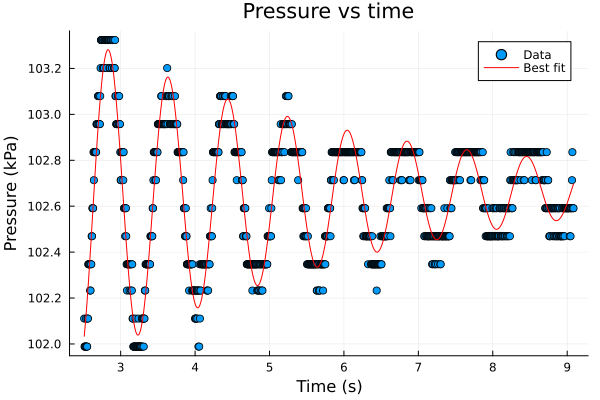

Parameters: [1.3843941819141345, 0.263668469606893, 7.821882493179534, -1.7536361686184174, -0.007530481627686786, 102.60418563041671]
Parameter errors (std dev): [0.037276003327093465, 0.005996312396990291, 0.005760891275530423, 0.025424675879754628, 0.0012195871442183068, 0.007456112933372384]
Frequency error (%): 1.04 ± 0.4
Experimental γ: 1.371 ± 0.011
γ error (%): 2.07 ± 0.79


(7.822 ± 0.012, 1.371 ± 0.011)

In [19]:
t10 = [2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54,	2.545,	2.55,	2.555,	2.56,	2.565,	2.57,	2.575,	2.58,	2.585,	2.59,	2.595,	2.6,	2.605,	2.61,	2.615,	2.62,	2.625,	2.63,	2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965,	2.97,	2.975,	2.98,	2.985,	2.99,	2.995,	3,	3.005,	3.01,	3.015,	3.02,	3.025,	3.03,	3.035,	3.04,	3.045,	3.05,	3.055,	3.06,	3.065,	3.07,	3.075,	3.08,	3.085,	3.09,	3.095,	3.1,	3.105,	3.11,	3.115,	3.12,	3.125,	3.13,	3.135,	3.14,	3.145,	3.15,	3.155,	3.16,	3.165,	3.17,	3.175,	3.18,	3.185,	3.19,	3.195,	3.2,	3.205,	3.21,	3.215,	3.22,	3.225,	3.23,	3.235,	3.24,	3.245,	3.25,	3.255,	3.26,	3.265,	3.27,	3.275,	3.28,	3.285,	3.29,	3.295,	3.3,	3.305,	3.31,	3.315,	3.32,	3.325,	3.33,	3.335,	3.34,	3.345,	3.35,	3.355,	3.36,	3.365,	3.37,	3.375,	3.38,	3.385,	3.39,	3.395,	3.4,	3.405,	3.41,	3.415,	3.42,	3.425,	3.43,	3.435,	3.44,	3.445,	3.45,	3.455,	3.46,	3.465,	3.47,	3.475,	3.48,	3.485,	3.49,	3.495,	3.5,	3.505,	3.51,	3.515,	3.52,	3.525,	3.53,	3.535,	3.54,	3.545,	3.55,	3.555,	3.56,	3.565,	3.57,	3.575,	3.58,	3.585,	3.59,	3.595,	3.6,	3.605,	3.61,	3.615,	3.62,	3.625,	3.63,	3.635,	3.64,	3.645,	3.65,	3.655,	3.66,	3.665,	3.67,	3.675,	3.68,	3.685,	3.69,	3.695,	3.7,	3.705,	3.71,	3.715,	3.72,	3.725,	3.73,	3.735,	3.74,	3.745,	3.75,	3.755,	3.76,	3.765,	3.77,	3.775,	3.78,	3.785,	3.79,	3.795,	3.8,	3.805,	3.81,	3.815,	3.82,	3.825,	3.83,	3.835,	3.84,	3.845,	3.85,	3.855,	3.86,	3.865,	3.87,	3.875,	3.88,	3.885,	3.89,	3.895,	3.9,	3.905,	3.91,	3.915,	3.92,	3.925,	3.93,	3.935,	3.94,	3.945,	3.95,	3.955,	3.96,	3.965,	3.97,	3.975,	3.98,	3.985,	3.99,	3.995,	4,	4.005,	4.01,	4.015,	4.02,	4.025,	4.03,	4.035,	4.04,	4.045,	4.05,	4.055,	4.06,	4.065,	4.07,	4.075,	4.08,	4.085,	4.09,	4.095,	4.1,	4.105,	4.11,	4.115,	4.12,	4.125,	4.13,	4.135,	4.14,	4.145,	4.15,	4.155,	4.16,	4.165,	4.17,	4.175,	4.18,	4.185,	4.19,	4.195,	4.2,	4.205,	4.21,	4.215,	4.22,	4.225,	4.23,	4.235,	4.24,	4.245,	4.25,	4.255,	4.26,	4.265,	4.27,	4.275,	4.28,	4.285,	4.29,	4.295,	4.3,	4.305,	4.31,	4.315,	4.32,	4.325,	4.33,	4.335,	4.34,	4.345,	4.35,	4.355,	4.36,	4.365,	4.37,	4.375,	4.38,	4.385,	4.39,	4.395,	4.4,	4.405,	4.41,	4.415,	4.42,	4.425,	4.43,	4.435,	4.44,	4.445,	4.45,	4.455,	4.46,	4.465,	4.47,	4.475,	4.48,	4.485,	4.49,	4.495,	4.5,	4.505,	4.51,	4.515,	4.52,	4.525,	4.53,	4.535,	4.54,	4.545,	4.55,	4.555,	4.56,	4.565,	4.57,	4.575,	4.58,	4.585,	4.59,	4.595,	4.6,	4.605,	4.61,	4.615,	4.62,	4.625,	4.63,	4.635,	4.64,	4.645,	4.65,	4.655,	4.66,	4.665,	4.67,	4.675,	4.68,	4.685,	4.69,	4.695,	4.7,	4.705,	4.71,	4.715,	4.72,	4.725,	4.73,	4.735,	4.74,	4.745,	4.75,	4.755,	4.76,	4.765,	4.77,	4.775,	4.78,	4.785,	4.79,	4.795,	4.8,	4.805,	4.81,	4.815,	4.82,	4.825,	4.83,	4.835,	4.84,	4.845,	4.85,	4.855,	4.86,	4.865,	4.87,	4.875,	4.88,	4.885,	4.89,	4.895,	4.9,	4.905,	4.91,	4.915,	4.92,	4.925,	4.93,	4.935,	4.94,	4.945,	4.95,	4.955,	4.96,	4.965,	4.97,	4.975,	4.98,	4.985,	4.99,	4.995,	5,	5.005,	5.01,	5.015,	5.02,	5.025,	5.03,	5.035,	5.04,	5.045,	5.05,	5.055,	5.06,	5.065,	5.07,	5.075,	5.08,	5.085,	5.09,	5.095,	5.1,	5.105,	5.11,	5.115,	5.12,	5.125,	5.13,	5.135,	5.14,	5.145,	5.15,	5.155,	5.16,	5.165,	5.17,	5.175,	5.18,	5.185,	5.19,	5.195,	5.2,	5.205,	5.21,	5.215,	5.22,	5.225,	5.23,	5.235,	5.24,	5.245,	5.25,	5.255,	5.26,	5.265,	5.27,	5.275,	5.28,	5.285,	5.29,	5.295,	5.3,	5.305,	5.31,	5.315,	5.32,	5.325,	5.33,	5.335,	5.34,	5.345,	5.35,	5.355,	5.36,	5.365,	5.37,	5.375,	5.38,	5.385,	5.39,	5.395,	5.4,	5.405,	5.41,	5.415,	5.42,	5.425,	5.43,	5.435,	5.44,	5.445,	5.45,	5.455,	5.46,	5.465,	5.47,	5.475,	5.48,	5.485,	5.49,	5.495,	5.5,	5.505,	5.51,	5.515,	5.52,	5.525,	5.53,	5.535,	5.54,	5.545,	5.55,	5.555,	5.56,	5.565,	5.57,	5.575,	5.58,	5.585,	5.59,	5.595,	5.6,	5.605,	5.61,	5.615,	5.62,	5.625,	5.63,	5.635,	5.64,	5.645,	5.65,	5.655,	5.66,	5.665,	5.67,	5.675,	5.68,	5.685,	5.69,	5.695,	5.7,	5.705,	5.71,	5.715,	5.72,	5.725,	5.73,	5.735,	5.74,	5.745,	5.75,	5.755,	5.76,	5.765,	5.77,	5.775,	5.78,	5.785,	5.79,	5.795,	5.8,	5.805,	5.81,	5.815,	5.82,	5.825,	5.83,	5.835,	5.84,	5.845,	5.85,	5.855,	5.86,	5.865,	5.87,	5.875,	5.88,	5.885,	5.89,	5.895,	5.9,	5.905,	5.91,	5.915,	5.92,	5.925,	5.93,	5.935,	5.94,	5.945,	5.95,	5.955,	5.96,	5.965,	5.97,	5.975,	5.98,	5.985,	5.99,	5.995,	6,	6.005,	6.01,	6.015,	6.02,	6.025,	6.03,	6.035,	6.04,	6.045,	6.05,	6.055,	6.06,	6.065,	6.07,	6.075,	6.08,	6.085,	6.09,	6.095,	6.1,	6.105,	6.11,	6.115,	6.12,	6.125,	6.13,	6.135,	6.14,	6.145,	6.15,	6.155,	6.16,	6.165,	6.17,	6.175,	6.18,	6.185,	6.19,	6.195,	6.2,	6.205,	6.21,	6.215,	6.22,	6.225,	6.23,	6.235,	6.24,	6.245,	6.25,	6.255,	6.26,	6.265,	6.27,	6.275,	6.28,	6.285,	6.29,	6.295,	6.3,	6.305,	6.31,	6.315,	6.32,	6.325,	6.33,	6.335,	6.34,	6.345,	6.35,	6.355,	6.36,	6.365,	6.37,	6.375,	6.38,	6.385,	6.39,	6.395,	6.4,	6.405,	6.41,	6.415,	6.42,	6.425,	6.43,	6.435,	6.44,	6.445,	6.45,	6.455,	6.46,	6.465,	6.47,	6.475,	6.48,	6.485,	6.49,	6.495,	6.5,	6.505,	6.51,	6.515,	6.52,	6.525,	6.53,	6.535,	6.54,	6.545,	6.55,	6.555,	6.56,	6.565,	6.57,	6.575,	6.58,	6.585,	6.59,	6.595,	6.6,	6.605,	6.61,	6.615,	6.62,	6.625,	6.63,	6.635,	6.64,	6.645,	6.65,	6.655,	6.66,	6.665,	6.67,	6.675,	6.68,	6.685,	6.69,	6.695,	6.7,	6.705,	6.71,	6.715,	6.72,	6.725,	6.73,	6.735,	6.74,	6.745,	6.75,	6.755,	6.76,	6.765,	6.77,	6.775,	6.78,	6.785,	6.79,	6.795,	6.8,	6.805,	6.81,	6.815,	6.82,	6.825,	6.83,	6.835,	6.84,	6.845,	6.85,	6.855,	6.86,	6.865,	6.87,	6.875,	6.88,	6.885,	6.89,	6.895,	6.9,	6.905,	6.91,	6.915,	6.92,	6.925,	6.93,	6.935,	6.94,	6.945,	6.95,	6.955,	6.96,	6.965,	6.97,	6.975,	6.98,	6.985,	6.99,	6.995,	7,	7.005,	7.01,	7.015,	7.02,	7.025,	7.03,	7.035,	7.04,	7.045,	7.05,	7.055,	7.06,	7.065,	7.07,	7.075,	7.08,	7.085,	7.09,	7.095,	7.1,	7.105,	7.11,	7.115,	7.12,	7.125,	7.13,	7.135,	7.14,	7.145,	7.15,	7.155,	7.16,	7.165,	7.17,	7.175,	7.18,	7.185,	7.19,	7.195,	7.2,	7.205,	7.21,	7.215,	7.22,	7.225,	7.23,	7.235,	7.24,	7.245,	7.25,	7.255,	7.26,	7.265,	7.27,	7.275,	7.28,	7.285,	7.29,	7.295,	7.3,	7.305,	7.31,	7.315,	7.32,	7.325,	7.33,	7.335,	7.34,	7.345,	7.35,	7.355,	7.36,	7.365,	7.37,	7.375,	7.38,	7.385,	7.39,	7.395,	7.4,	7.405,	7.41,	7.415,	7.42,	7.425,	7.43,	7.435,	7.44,	7.445,	7.45,	7.455,	7.46,	7.465,	7.47,	7.475,	7.48,	7.485,	7.49,	7.495,	7.5,	7.505,	7.51,	7.515,	7.52,	7.525,	7.53,	7.535,	7.54,	7.545,	7.55,	7.555,	7.56,	7.565,	7.57,	7.575,	7.58,	7.585,	7.59,	7.595,	7.6,	7.605,	7.61,	7.615,	7.62,	7.625,	7.63,	7.635,	7.64,	7.645,	7.65,	7.655,	7.66,	7.665,	7.67,	7.675,	7.68,	7.685,	7.69,	7.695,	7.7,	7.705,	7.71,	7.715,	7.72,	7.725,	7.73,	7.735,	7.74,	7.745,	7.75,	7.755,	7.76,	7.765,	7.77,	7.775,	7.78,	7.785,	7.79,	7.795,	7.8,	7.805,	7.81,	7.815,	7.82,	7.825,	7.83,	7.835,	7.84,	7.845,	7.85,	7.855,	7.86,	7.865,	7.87,	7.875,	7.88,	7.885,	7.89,	7.895,	7.9,	7.905,	7.91,	7.915,	7.92,	7.925,	7.93,	7.935,	7.94,	7.945,	7.95,	7.955,	7.96,	7.965,	7.97,	7.975,	7.98,	7.985,	7.99,	7.995,	8,	8.005,	8.01,	8.015,	8.02,	8.025,	8.03,	8.035,	8.04,	8.045,	8.05,	8.055,	8.06,	8.065,	8.07,	8.075,	8.08,	8.085,	8.09,	8.095,	8.1,	8.105,	8.11,	8.115,	8.12,	8.125,	8.13,	8.135,	8.14,	8.145,	8.15,	8.155,	8.16,	8.165,	8.17,	8.175,	8.18,	8.185,	8.19,	8.195,	8.2,	8.205,	8.21,	8.215,	8.22,	8.225,	8.23,	8.235,	8.24,	8.245,	8.25,	8.255,	8.26,	8.265,	8.27,	8.275,	8.28,	8.285,	8.29,	8.295,	8.3,	8.305,	8.31,	8.315,	8.32,	8.325,	8.33,	8.335,	8.34,	8.345,	8.35,	8.355,	8.36,	8.365,	8.37,	8.375,	8.38,	8.385,	8.39,	8.395,	8.4,	8.405,	8.41,	8.415,	8.42,	8.425,	8.43,	8.435,	8.44,	8.445,	8.45,	8.455,	8.46,	8.465,	8.47,	8.475,	8.48,	8.485,	8.49,	8.495,	8.5,	8.505,	8.51,	8.515,	8.52,	8.525,	8.53,	8.535,	8.54,	8.545,	8.55,	8.555,	8.56,	8.565,	8.57,	8.575,	8.58,	8.585,	8.59,	8.595,	8.6,	8.605,	8.61,	8.615,	8.62,	8.625,	8.63,	8.635,	8.64,	8.645,	8.65,	8.655,	8.66,	8.665,	8.67,	8.675,	8.68,	8.685,	8.69,	8.695,	8.7,	8.705,	8.71,	8.715,	8.72,	8.725,	8.73,	8.735,	8.74,	8.745,	8.75,	8.755,	8.76,	8.765,	8.77,	8.775,	8.78,	8.785,	8.79,	8.795,	8.8,	8.805,	8.81,	8.815,	8.82,	8.825,	8.83,	8.835,	8.84,	8.845,	8.85,	8.855,	8.86,	8.865,	8.87,	8.875,	8.88,	8.885,	8.89,	8.895,	8.9,	8.905,	8.91,	8.915,	8.92,	8.925,	8.93,	8.935,	8.94,	8.945,	8.95,	8.955,	8.96,	8.965,	8.97,	8.975,	8.98,	8.985,	8.99,	8.995,	9,	9.005,	9.01,	9.015,	9.02,	9.025,	9.03,	9.035,	9.04,	9.045,	9.05,	9.055,	9.06,	9.065,	9.07,	9.075,	9.08,	9.085]
p10 = [102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.110523223877,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	102.110523223877,	102.110523223877,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.201526641845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.232593536377,	102.232593536377,	102.232593536377,	102.110523223877,	102.110523223877,	102.110523223877,	102.110523223877,	102.232593536377,	102.232593536377,	102.110523223877,	102.232593536377,	102.232593536377,	101.988452911377,	102.232593536377,	101.988452911377,	102.347034454345,	102.110523223877,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.957386016845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845, 102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.469104766845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.347034454345,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.713245391845,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.713245391845,	102.835315704345,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.835315704345,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345];

t = t10
p = p10

ωe, γe = analysis(t, p, V2, P2, model)

#push!(ωs[3], ωe)
#push!(γs[3], γe)

#This run is redone in the next cell with less later data points

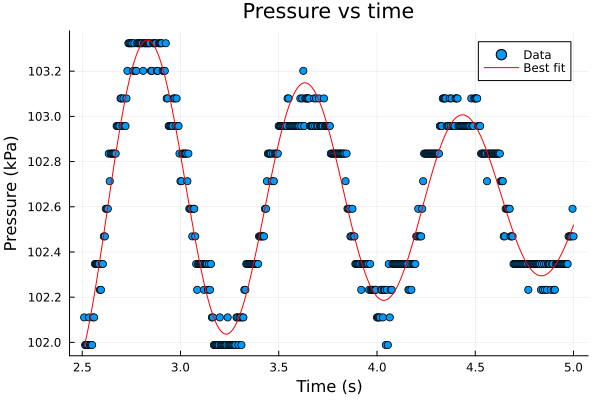

Parameters: [2.0306113723400867, 0.37688408837598864, 7.834724684513711, -1.810971648229054, 0.008846575491320173, 102.6650885861882]
Parameter errors (std dev): [0.11663240723890773, 0.016434817590788367, 0.01586604023916925, 0.05451071469684755, 0.005664595438579392, 0.021777735162182843]
Frequency error (%): 0.88 ± 0.55
Experimental γ: 1.376 ± 0.015
γ error (%): 1.7 ± 1.1


In [20]:
t10 = [2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54,	2.545,	2.55,	2.555,	2.56,	2.565,	2.57,	2.575,	2.58,	2.585,	2.59,	2.595,	2.6,	2.605,	2.61,	2.615,	2.62,	2.625,	2.63,	2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965,	2.97,	2.975,	2.98,	2.985,	2.99,	2.995,	3,	3.005,	3.01,	3.015,	3.02,	3.025,	3.03,	3.035,	3.04,	3.045,	3.05,	3.055,	3.06,	3.065,	3.07,	3.075,	3.08,	3.085,	3.09,	3.095,	3.1,	3.105,	3.11,	3.115,	3.12,	3.125,	3.13,	3.135,	3.14,	3.145,	3.15,	3.155,	3.16,	3.165,	3.17,	3.175,	3.18,	3.185,	3.19,	3.195,	3.2,	3.205,	3.21,	3.215,	3.22,	3.225,	3.23,	3.235,	3.24,	3.245,	3.25,	3.255,	3.26,	3.265,	3.27,	3.275,	3.28,	3.285,	3.29,	3.295,	3.3,	3.305,	3.31,	3.315,	3.32,	3.325,	3.33,	3.335,	3.34,	3.345,	3.35,	3.355,	3.36,	3.365,	3.37,	3.375,	3.38,	3.385,	3.39,	3.395,	3.4,	3.405,	3.41,	3.415,	3.42,	3.425,	3.43,	3.435,	3.44,	3.445,	3.45,	3.455,	3.46,	3.465,	3.47,	3.475,	3.48,	3.485,	3.49,	3.495,	3.5,	3.505,	3.51,	3.515,	3.52,	3.525,	3.53,	3.535,	3.54,	3.545,	3.55,	3.555,	3.56,	3.565,	3.57,	3.575,	3.58,	3.585,	3.59,	3.595,	3.6,	3.605,	3.61,	3.615,	3.62,	3.625,	3.63,	3.635,	3.64,	3.645,	3.65,	3.655,	3.66,	3.665,	3.67,	3.675,	3.68,	3.685,	3.69,	3.695,	3.7,	3.705,	3.71,	3.715,	3.72,	3.725,	3.73,	3.735,	3.74,	3.745,	3.75,	3.755,	3.76,	3.765,	3.77,	3.775,	3.78,	3.785,	3.79,	3.795,	3.8,	3.805,	3.81,	3.815,	3.82,	3.825,	3.83,	3.835,	3.84,	3.845,	3.85,	3.855,	3.86,	3.865,	3.87,	3.875,	3.88,	3.885,	3.89,	3.895,	3.9,	3.905,	3.91,	3.915,	3.92,	3.925,	3.93,	3.935,	3.94,	3.945,	3.95,	3.955,	3.96,	3.965,	3.97,	3.975,	3.98,	3.985,	3.99,	3.995,	4,	4.005,	4.01,	4.015,	4.02,	4.025,	4.03,	4.035,	4.04,	4.045,	4.05,	4.055,	4.06,	4.065,	4.07,	4.075,	4.08,	4.085,	4.09,	4.095,	4.1,	4.105,	4.11,	4.115,	4.12,	4.125,	4.13,	4.135,	4.14,	4.145,	4.15,	4.155,	4.16,	4.165,	4.17,	4.175,	4.18,	4.185,	4.19,	4.195,	4.2,	4.205,	4.21,	4.215,	4.22,	4.225,	4.23,	4.235,	4.24,	4.245,	4.25,	4.255,	4.26,	4.265,	4.27,	4.275,	4.28,	4.285,	4.29,	4.295,	4.3,	4.305,	4.31,	4.315,	4.32,	4.325,	4.33,	4.335,	4.34,	4.345,	4.35,	4.355,	4.36,	4.365,	4.37,	4.375,	4.38,	4.385,	4.39,	4.395,	4.4,	4.405,	4.41,	4.415,	4.42,	4.425,	4.43,	4.435,	4.44,	4.445,	4.45,	4.455,	4.46,	4.465,	4.47,	4.475,	4.48,	4.485,	4.49,	4.495,	4.5,	4.505,	4.51,	4.515,	4.52,	4.525,	4.53,	4.535,	4.54,	4.545,	4.55,	4.555,	4.56,	4.565,	4.57,	4.575,	4.58,	4.585,	4.59,	4.595,	4.6,	4.605,	4.61,	4.615,	4.62,	4.625,	4.63,	4.635,	4.64,	4.645,	4.65,	4.655,	4.66,	4.665,	4.67,	4.675,	4.68,	4.685,	4.69,	4.695,	4.7,	4.705,	4.71,	4.715,	4.72,	4.725,	4.73,	4.735,	4.74,	4.745,	4.75,	4.755,	4.76,	4.765,	4.77,	4.775,	4.78,	4.785,	4.79,	4.795,	4.8,	4.805,	4.81,	4.815,	4.82,	4.825,	4.83,	4.835,	4.84,	4.845,	4.85,	4.855,	4.86,	4.865,	4.87,	4.875,	4.88,	4.885,	4.89,	4.895,	4.9,	4.905,	4.91,	4.915,	4.92,	4.925,	4.93,	4.935,	4.94,	4.945,	4.95,	4.955,	4.96,	4.965,	4.97,	4.975,	4.98,	4.985,	4.99,	4.995,	5,	5.005,	5.01,	5.015,	5.02,	5.025,	5.03,	5.035,	5.04,	5.045,	5.05,	5.055,	5.06,	5.065,	5.07,	5.075,	5.08,	5.085,	5.09,	5.095,	5.1,	5.105,	5.11,	5.115,	5.12,	5.125,	5.13,	5.135,	5.14,	5.145,	5.15,	5.155,	5.16,	5.165,	5.17,	5.175,	5.18,	5.185,	5.19,	5.195,	5.2,	5.205,	5.21,	5.215,	5.22,	5.225,	5.23,	5.235,	5.24,	5.245,	5.25,	5.255,	5.26,	5.265,	5.27,	5.275,	5.28,	5.285,	5.29,	5.295,	5.3,	5.305,	5.31,	5.315,	5.32,	5.325,	5.33,	5.335,	5.34,	5.345,	5.35,	5.355,	5.36,	5.365,	5.37,	5.375,	5.38,	5.385,	5.39,	5.395,	5.4,	5.405,	5.41,	5.415,	5.42,	5.425,	5.43,	5.435,	5.44,	5.445,	5.45,	5.455,	5.46,	5.465,	5.47,	5.475,	5.48,	5.485,	5.49,	5.495,	5.5,	5.505,	5.51,	5.515,	5.52,	5.525,	5.53,	5.535,	5.54,	5.545,	5.55,	5.555,	5.56,	5.565,	5.57,	5.575,	5.58,	5.585,	5.59,	5.595,	5.6,	5.605,	5.61,	5.615,	5.62,	5.625,	5.63,	5.635,	5.64,	5.645,	5.65,	5.655,	5.66,	5.665,	5.67,	5.675,	5.68,	5.685,	5.69,	5.695,	5.7,	5.705,	5.71,	5.715,	5.72,	5.725,	5.73,	5.735,	5.74,	5.745,	5.75,	5.755,	5.76,	5.765,	5.77,	5.775,	5.78,	5.785,	5.79,	5.795,	5.8,	5.805,	5.81,	5.815,	5.82,	5.825,	5.83,	5.835,	5.84,	5.845,	5.85,	5.855,	5.86,	5.865,	5.87,	5.875,	5.88,	5.885,	5.89,	5.895,	5.9,	5.905,	5.91,	5.915,	5.92,	5.925,	5.93,	5.935,	5.94,	5.945,	5.95,	5.955,	5.96,	5.965,	5.97,	5.975,	5.98,	5.985,	5.99,	5.995,	6,	6.005,	6.01,	6.015,	6.02,	6.025,	6.03,	6.035,	6.04,	6.045,	6.05,	6.055,	6.06,	6.065,	6.07,	6.075,	6.08,	6.085,	6.09,	6.095,	6.1,	6.105,	6.11,	6.115,	6.12,	6.125,	6.13,	6.135,	6.14,	6.145,	6.15,	6.155,	6.16,	6.165,	6.17,	6.175,	6.18,	6.185,	6.19,	6.195,	6.2,	6.205,	6.21,	6.215,	6.22,	6.225,	6.23,	6.235,	6.24,	6.245,	6.25,	6.255,	6.26,	6.265,	6.27,	6.275,	6.28,	6.285,	6.29,	6.295,	6.3,	6.305,	6.31,	6.315,	6.32,	6.325,	6.33,	6.335,	6.34,	6.345,	6.35,	6.355,	6.36,	6.365,	6.37,	6.375,	6.38,	6.385,	6.39,	6.395,	6.4,	6.405,	6.41,	6.415,	6.42,	6.425,	6.43,	6.435,	6.44,	6.445,	6.45,	6.455,	6.46,	6.465,	6.47,	6.475,	6.48,	6.485,	6.49,	6.495,	6.5,	6.505,	6.51,	6.515,	6.52,	6.525,	6.53,	6.535,	6.54,	6.545,	6.55,	6.555,	6.56,	6.565,	6.57,	6.575,	6.58,	6.585,	6.59,	6.595,	6.6,	6.605,	6.61,	6.615,	6.62,	6.625,	6.63,	6.635,	6.64,	6.645,	6.65,	6.655,	6.66,	6.665,	6.67,	6.675,	6.68,	6.685,	6.69,	6.695,	6.7,	6.705,	6.71,	6.715,	6.72,	6.725,	6.73,	6.735,	6.74,	6.745,	6.75,	6.755,	6.76,	6.765,	6.77,	6.775,	6.78,	6.785,	6.79,	6.795,	6.8,	6.805,	6.81,	6.815,	6.82,	6.825,	6.83,	6.835,	6.84,	6.845,	6.85,	6.855,	6.86,	6.865,	6.87,	6.875,	6.88,	6.885,	6.89,	6.895,	6.9,	6.905,	6.91,	6.915,	6.92,	6.925,	6.93,	6.935,	6.94,	6.945,	6.95,	6.955,	6.96,	6.965,	6.97,	6.975,	6.98,	6.985,	6.99,	6.995,	7,	7.005,	7.01,	7.015,	7.02,	7.025,	7.03,	7.035,	7.04,	7.045,	7.05,	7.055,	7.06,	7.065,	7.07,	7.075,	7.08,	7.085,	7.09,	7.095,	7.1,	7.105,	7.11,	7.115,	7.12,	7.125,	7.13,	7.135,	7.14,	7.145,	7.15,	7.155,	7.16,	7.165,	7.17,	7.175,	7.18,	7.185,	7.19,	7.195,	7.2,	7.205,	7.21,	7.215,	7.22,	7.225,	7.23,	7.235,	7.24,	7.245,	7.25,	7.255,	7.26,	7.265,	7.27,	7.275,	7.28,	7.285,	7.29,	7.295,	7.3,	7.305,	7.31,	7.315,	7.32,	7.325,	7.33,	7.335,	7.34,	7.345,	7.35,	7.355,	7.36,	7.365,	7.37,	7.375,	7.38,	7.385,	7.39,	7.395,	7.4,	7.405,	7.41,	7.415,	7.42,	7.425,	7.43,	7.435,	7.44,	7.445,	7.45,	7.455,	7.46,	7.465,	7.47,	7.475,	7.48,	7.485,	7.49,	7.495,	7.5,	7.505,	7.51,	7.515,	7.52,	7.525,	7.53,	7.535,	7.54,	7.545,	7.55,	7.555,	7.56,	7.565,	7.57,	7.575,	7.58,	7.585,	7.59,	7.595,	7.6,	7.605,	7.61,	7.615,	7.62,	7.625,	7.63,	7.635,	7.64,	7.645,	7.65,	7.655,	7.66,	7.665,	7.67,	7.675,	7.68,	7.685,	7.69,	7.695,	7.7,	7.705,	7.71,	7.715,	7.72,	7.725,	7.73,	7.735,	7.74,	7.745,	7.75,	7.755,	7.76,	7.765,	7.77,	7.775,	7.78,	7.785,	7.79,	7.795,	7.8,	7.805,	7.81,	7.815,	7.82,	7.825,	7.83,	7.835,	7.84,	7.845,	7.85,	7.855,	7.86,	7.865,	7.87,	7.875,	7.88,	7.885,	7.89,	7.895,	7.9,	7.905,	7.91,	7.915,	7.92,	7.925,	7.93,	7.935,	7.94,	7.945,	7.95,	7.955,	7.96,	7.965,	7.97,	7.975,	7.98,	7.985,	7.99,	7.995,	8,	8.005,	8.01,	8.015,	8.02,	8.025,	8.03,	8.035,	8.04,	8.045,	8.05,	8.055,	8.06,	8.065,	8.07,	8.075,	8.08,	8.085,	8.09,	8.095,	8.1,	8.105,	8.11,	8.115,	8.12,	8.125,	8.13,	8.135,	8.14,	8.145,	8.15,	8.155,	8.16,	8.165,	8.17,	8.175,	8.18,	8.185,	8.19,	8.195,	8.2,	8.205,	8.21,	8.215,	8.22,	8.225,	8.23,	8.235,	8.24,	8.245,	8.25,	8.255,	8.26,	8.265,	8.27,	8.275,	8.28,	8.285,	8.29,	8.295,	8.3,	8.305,	8.31,	8.315,	8.32,	8.325,	8.33,	8.335,	8.34,	8.345,	8.35,	8.355,	8.36,	8.365,	8.37,	8.375,	8.38,	8.385,	8.39,	8.395,	8.4,	8.405,	8.41,	8.415,	8.42,	8.425,	8.43,	8.435,	8.44,	8.445,	8.45,	8.455,	8.46,	8.465,	8.47,	8.475,	8.48,	8.485,	8.49,	8.495,	8.5,	8.505,	8.51,	8.515,	8.52,	8.525,	8.53,	8.535,	8.54,	8.545,	8.55,	8.555,	8.56,	8.565,	8.57,	8.575,	8.58,	8.585,	8.59,	8.595,	8.6,	8.605,	8.61,	8.615,	8.62,	8.625,	8.63,	8.635,	8.64,	8.645,	8.65,	8.655,	8.66,	8.665,	8.67,	8.675,	8.68,	8.685,	8.69,	8.695,	8.7,	8.705,	8.71,	8.715,	8.72,	8.725,	8.73,	8.735,	8.74,	8.745,	8.75,	8.755,	8.76,	8.765,	8.77,	8.775,	8.78,	8.785,	8.79,	8.795,	8.8,	8.805,	8.81,	8.815,	8.82,	8.825,	8.83,	8.835,	8.84,	8.845,	8.85,	8.855,	8.86,	8.865,	8.87,	8.875,	8.88,	8.885,	8.89,	8.895,	8.9,	8.905,	8.91,	8.915,	8.92,	8.925,	8.93,	8.935,	8.94,	8.945,	8.95,	8.955,	8.96,	8.965,	8.97,	8.975,	8.98,	8.985,	8.99,	8.995,	9,	9.005,	9.01,	9.015,	9.02,	9.025,	9.03,	9.035,	9.04,	9.045,	9.05,	9.055,	9.06,	9.065,	9.07,	9.075,	9.08,	9.085]
p10 = [102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.110523223877,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	102.110523223877,	102.110523223877,	101.988452911377,	102.110523223877,	102.110523223877,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.201526641845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.232593536377,	102.232593536377,	102.232593536377,	102.110523223877,	102.110523223877,	102.110523223877,	102.110523223877,	102.232593536377,	102.232593536377,	102.110523223877,	102.232593536377,	102.232593536377,	101.988452911377,	102.232593536377,	101.988452911377,	102.347034454345,	102.110523223877,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.957386016845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845, 102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.469104766845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.347034454345,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.713245391845,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.713245391845,	102.835315704345,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.835315704345,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345];

t = t10[1:499]
p = p10[1:499]

ωe, γe = analysis(t, p, V2, P2, model)

push!(ωs[3], ωe)
push!(γs[3], γe);

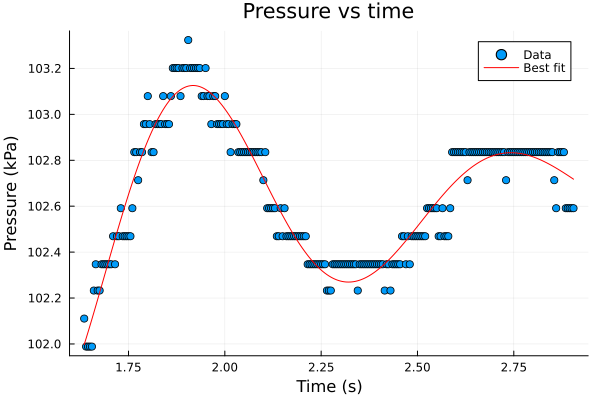

Parameters: [6.483122494153159, 1.2727499213131197, 7.661866505757982, -0.7010855299160659, -0.08416263475841028, 102.40558915284939]
Parameter errors (std dev): [1.0579020213487227, 0.07743965358053057, 0.07309427834416528, 0.149105808077047, 0.02211516613328845, 0.052332440868813467]
Frequency error (%): 3.1 ± 1.9
Experimental γ: 1.316 ± 0.051
γ error (%): 6.0 ± 3.7


In [21]:
t11 = [1.635,	1.64,	1.645,	1.65,	1.655,	1.66,	1.665,	1.67,	1.675,	1.68,	1.685,	1.69,	1.695,	1.7,	1.705,	1.71,	1.715,	1.72,	1.725,	1.73,	1.735,	1.74,	1.745,	1.75,	1.755,	1.76,	1.765,	1.77,	1.775,	1.78,	1.785,	1.79,	1.795,	1.8,	1.805,	1.81,	1.815,	1.82,	1.825,	1.83,	1.835,	1.84,	1.845,	1.85,	1.855,	1.86,	1.865,	1.87,	1.875,	1.88,	1.885,	1.89,	1.895,	1.9,	1.905,	1.91,	1.915,	1.92,	1.925,	1.93,	1.935,	1.94,	1.945,	1.95,	1.955,	1.96,	1.965,	1.97,	1.975,	1.98,	1.985,	1.99,	1.995,	2,	2.005,	2.01,	2.015,	2.02,	2.025,	2.03,	2.035,	2.04,	2.045,	2.05,	2.055,	2.06,	2.065,	2.07,	2.075,	2.08,	2.085,	2.09,	2.095,	2.1,	2.105,	2.11,	2.115,	2.12,	2.125,	2.13,	2.135,	2.14,	2.145,	2.15,	2.155,	2.16,	2.165,	2.17,	2.175,	2.18,	2.185,	2.19,	2.195,	2.2,	2.205,	2.21,	2.215,	2.22,	2.225,	2.23,	2.235,	2.24,	2.245,	2.25,	2.255,	2.26,	2.265,	2.27,	2.275,	2.28,	2.285,	2.29,	2.295,	2.3,	2.305,	2.31,	2.315,	2.32,	2.325,	2.33,	2.335,	2.34,	2.345,	2.35,	2.355,	2.36,	2.365,	2.37,	2.375,	2.38,	2.385,	2.39,	2.395,	2.4,	2.405,	2.41,	2.415,	2.42,	2.425,	2.43,	2.435,	2.44,	2.445,	2.45,	2.455,	2.46,	2.465,	2.47,	2.475,	2.48,	2.485,	2.49,	2.495,	2.5,	2.505,	2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54,	2.545,	2.55,	2.555,	2.56,	2.565,	2.57,	2.575,	2.58,	2.585,	2.59,	2.595,	2.6,	2.605,	2.61,	2.615,	2.62,	2.625,	2.63,	2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905]
p11 = [102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	101.988452911377,	102.232593536377,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	103.079456329345,	103.201526641845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.347034454345,	102.469104766845,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345];

t = t11
p = p11

ωe, γe = analysis(t, p, V2, P2, model)

push!(ωs[3], ωe)
push!(γs[3], γe);

In [22]:
#new V and P
const V3 = (6023.8 ± 45)/1e6 #m^3
const P3 = 101900 ± 200 #Pa

push!(Vs, V3)
push!(Ps, P3)
push!(ωs, [])
push!(γs, []);

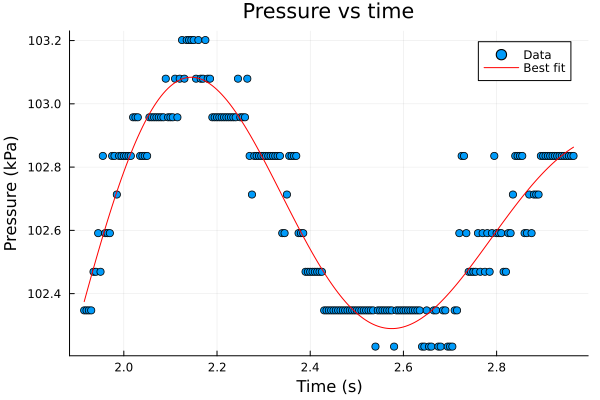

Parameters: [6.8759104526171155, 1.170773881432731, 6.9864323436737585, -0.9612900235091137, -0.20197084749926927, 102.09626113829287]
Parameter errors (std dev): [3.222257677084705, 0.18164111066553376, 0.29717622279691214, 0.6667020956565766, 0.12446761365534549, 0.3154220635257082]
Frequency error (%): 7.7 ± 7.9
Experimental γ: 1.19 ± 0.2
γ error (%): 15.0 ± 15.0


In [23]:
t12 = [1.915,	1.92,	1.925,	1.93,	1.935,	1.94,	1.945,	1.95,	1.955,	1.96,	1.965,	1.97,	1.975,	1.98,	1.985,	1.99,	1.995,	2,	2.005,	2.01,	2.015,	2.02,	2.025,	2.03,	2.035,	2.04,	2.045,	2.05,	2.055,	2.06,	2.065,	2.07,	2.075,	2.08,	2.085,	2.09,	2.095,	2.1,	2.105,	2.11,	2.115,	2.12,	2.125,	2.13,	2.135,	2.14,	2.145,	2.15,	2.155,	2.16,	2.165,	2.17,	2.175,	2.18,	2.185,	2.19,	2.195,	2.2,	2.205,	2.21,	2.215,	2.22,	2.225,	2.23,	2.235,	2.24,	2.245,	2.25,	2.255,	2.26,	2.265,	2.27,	2.275,	2.28,	2.285,	2.29,	2.295,	2.3,	2.305,	2.31,	2.315,	2.32,	2.325,	2.33,	2.335,	2.34,	2.345,	2.35,	2.355,	2.36,	2.365,	2.37,	2.375,	2.38,	2.385,	2.39,	2.395,	2.4,	2.405,	2.41,	2.415,	2.42,	2.425,	2.43,	2.435,	2.44,	2.445,	2.45,	2.455,	2.46,	2.465,	2.47,	2.475,	2.48,	2.485,	2.49,	2.495,	2.5,	2.505,	2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54,	2.545,	2.55,	2.555,	2.56,	2.565,	2.57,	2.575,	2.58,	2.585,	2.59,	2.595,	2.6,	2.605,	2.61,	2.615,	2.62,	2.625,	2.63,	2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965]
p12 = [102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.201526641845,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	103.201526641845,	103.079456329345,	103.079456329345,	103.201526641845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.591175079345,	102.835315704345,	102.835315704345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345];

t = t12
p = p12

ωe, γe = analysis(t, p, V3, P3, model)

push!(ωs[4], ωe)
push!(γs[4], γe);

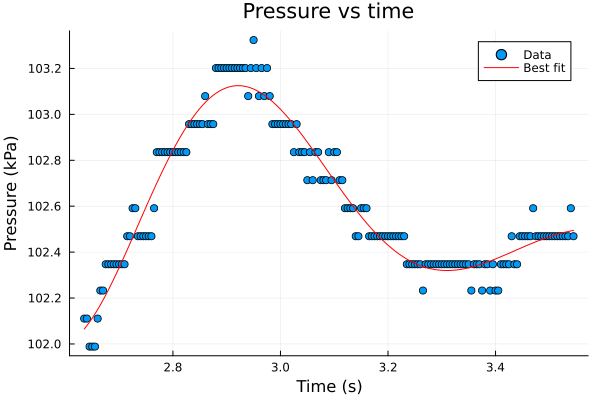

Parameters: [138.4611983453749, 1.9626103076319068, 8.965777170861237, -6.096122943150915, 0.4413658440024834, 103.9897254412675]
Parameter errors (std dev): [55.73476104787181, 0.14387228614416145, 0.2598089859312596, 0.7801801304022138, 0.07321923571267003, 0.2331519519774688]
Frequency error (%): 18.5 ± 6.9
Experimental γ: 1.96 ± 0.23
γ error (%): 40.0 ± 16.0


In [24]:
t13 = [2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965,	2.97,	2.975,	2.98,	2.985,	2.99,	2.995,	3,	3.005,	3.01,	3.015,	3.02,	3.025,	3.03,	3.035,	3.04,	3.045,	3.05,	3.055,	3.06,	3.065,	3.07,	3.075,	3.08,	3.085,	3.09,	3.095,	3.1,	3.105,	3.11,	3.115,	3.12,	3.125,	3.13,	3.135,	3.14,	3.145,	3.15,	3.155,	3.16,	3.165,	3.17,	3.175,	3.18,	3.185,	3.19,	3.195,	3.2,	3.205,	3.21,	3.215,	3.22,	3.225,	3.23,	3.235,	3.24,	3.245,	3.25,	3.255,	3.26,	3.265,	3.27,	3.275,	3.28,	3.285,	3.29,	3.295,	3.3,	3.305,	3.31,	3.315,	3.32,	3.325,	3.33,	3.335,	3.34,	3.345,	3.35,	3.355,	3.36,	3.365,	3.37,	3.375,	3.38,	3.385,	3.39,	3.395,	3.4,	3.405,	3.41,	3.415,	3.42,	3.425,	3.43,	3.435,	3.44,	3.445,	3.45,	3.455,	3.46,	3.465,	3.47,	3.475,	3.48,	3.485,	3.49,	3.495,	3.5,	3.505,	3.51,	3.515,	3.52,	3.525,	3.53,	3.535,	3.54,	3.545]
p13 = [102.110523223877,	102.110523223877,	101.988452911377,	101.988452911377,	101.988452911377,	102.110523223877,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	103.201526641845,	103.323596954345,	103.201526641845,	103.079456329345,	103.201526641845,	103.079456329345,	103.201526641845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.232593536377,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845];

t = t13
p = p13

ωe, γe = analysis(t, p, V3, P3, model)

push!(ωs[4], ωe)
push!(γs[4], γe);

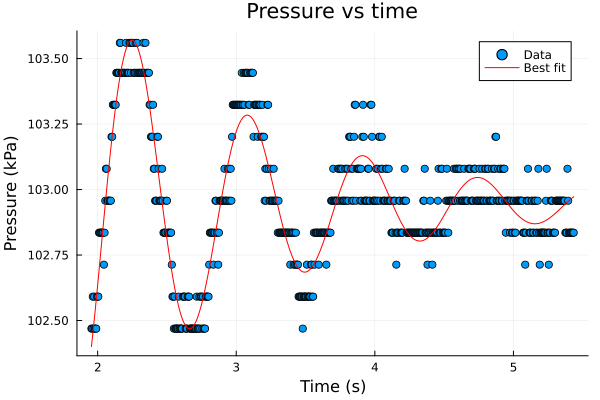

Parameters: [3.30403800940363, 0.7316525842684629, 7.563401967004213, -2.9627330860638947, -0.0031248805975149867, 102.92885734059607]
Parameter errors (std dev): [0.21413179130821705, 0.023432849907905444, 0.02129197961885747, 0.05661949124640872, 0.0035107735806428073, 0.01358835352982944]
Frequency error (%): 0.073 ± 0.68
Experimental γ: 1.398 ± 0.019
γ error (%): 0.15 ± 1.4


In [25]:
t14 = [1.955,	1.96,	1.965,	1.97,	1.975,	1.98,	1.985,	1.99,	1.995,	2,	2.005,	2.01,	2.015,	2.02,	2.025,	2.03,	2.035,	2.04,	2.045,	2.05,	2.055,	2.06,	2.065,	2.07,	2.075,	2.08,	2.085,	2.09,	2.095,	2.1,	2.105,	2.11,	2.115,	2.12,	2.125,	2.13,	2.135,	2.14,	2.145,	2.15,	2.155,	2.16,	2.165,	2.17,	2.175,	2.18,	2.185,	2.19,	2.195,	2.2,	2.205,	2.21,	2.215,	2.22,	2.225,	2.23,	2.235,	2.24,	2.245,	2.25,	2.255,	2.26,	2.265,	2.27,	2.275,	2.28,	2.285,	2.29,	2.295,	2.3,	2.305,	2.31,	2.315,	2.32,	2.325,	2.33,	2.335,	2.34,	2.345,	2.35,	2.355,	2.36,	2.365,	2.37,	2.375,	2.38,	2.385,	2.39,	2.395,	2.4,	2.405,	2.41,	2.415,	2.42,	2.425,	2.43,	2.435,	2.44,	2.445,	2.45,	2.455,	2.46,	2.465,	2.47,	2.475,	2.48,	2.485,	2.49,	2.495,	2.5,	2.505,	2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54,	2.545,	2.55,	2.555,	2.56,	2.565,	2.57,	2.575,	2.58,	2.585,	2.59,	2.595,	2.6,	2.605,	2.61,	2.615,	2.62,	2.625,	2.63,	2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965,	2.97,	2.975,	2.98,	2.985,	2.99,	2.995,	3,	3.005,	3.01,	3.015,	3.02,	3.025,	3.03,	3.035,	3.04,	3.045,	3.05,	3.055,	3.06,	3.065,	3.07,	3.075,	3.08,	3.085,	3.09,	3.095,	3.1,	3.105,	3.11,	3.115,	3.12,	3.125,	3.13,	3.135,	3.14,	3.145,	3.15,	3.155,	3.16,	3.165,	3.17,	3.175,	3.18,	3.185,	3.19,	3.195,	3.2,	3.205,	3.21,	3.215,	3.22,	3.225,	3.23,	3.235,	3.24,	3.245,	3.25,	3.255,	3.26,	3.265,	3.27,	3.275,	3.28,	3.285,	3.29,	3.295,	3.3,	3.305,	3.31,	3.315,	3.32,	3.325,	3.33,	3.335,	3.34,	3.345,	3.35,	3.355,	3.36,	3.365,	3.37,	3.375,	3.38,	3.385,	3.39,	3.395,	3.4,	3.405,	3.41,	3.415,	3.42,	3.425,	3.43,	3.435,	3.44,	3.445,	3.45,	3.455,	3.46,	3.465,	3.47,	3.475,	3.48,	3.485,	3.49,	3.495,	3.5,	3.505,	3.51,	3.515,	3.52,	3.525,	3.53,	3.535,	3.54,	3.545,	3.55,	3.555,	3.56,	3.565,	3.57,	3.575,	3.58,	3.585,	3.59,	3.595,	3.6,	3.605,	3.61,	3.615,	3.62,	3.625,	3.63,	3.635,	3.64,	3.645,	3.65,	3.655,	3.66,	3.665,	3.67,	3.675,	3.68,	3.685,	3.69,	3.695,	3.7,	3.705,	3.71,	3.715,	3.72,	3.725,	3.73,	3.735,	3.74,	3.745,	3.75,	3.755,	3.76,	3.765,	3.77,	3.775,	3.78,	3.785,	3.79,	3.795,	3.8,	3.805,	3.81,	3.815,	3.82,	3.825,	3.83,	3.835,	3.84,	3.845,	3.85,	3.855,	3.86,	3.865,	3.87,	3.875,	3.88,	3.885,	3.89,	3.895,	3.9,	3.905,	3.91,	3.915,	3.92,	3.925,	3.93,	3.935,	3.94,	3.945,	3.95,	3.955,	3.96,	3.965,	3.97,	3.975,	3.98,	3.985,	3.99,	3.995,	4,	4.005,	4.01,	4.015,	4.02,	4.025,	4.03,	4.035,	4.04,	4.045,	4.05,	4.055,	4.06,	4.065,	4.07,	4.075,	4.08,	4.085,	4.09,	4.095,	4.1,	4.105,	4.11,	4.115,	4.12,	4.125,	4.13,	4.135,	4.14,	4.145,	4.15,	4.155,	4.16,	4.165,	4.17,	4.175,	4.18,	4.185,	4.19,	4.195,	4.2,	4.205,	4.21,	4.215,	4.22,	4.225,	4.23,	4.235,	4.24,	4.245,	4.25,	4.255,	4.26,	4.265,	4.27,	4.275,	4.28,	4.285,	4.29,	4.295,	4.3,	4.305,	4.31,	4.315,	4.32,	4.325,	4.33,	4.335,	4.34,	4.345,	4.35,	4.355,	4.36,	4.365,	4.37,	4.375,	4.38,	4.385,	4.39,	4.395,	4.4,	4.405,	4.41,	4.415,	4.42,	4.425,	4.43,	4.435,	4.44,	4.445,	4.45,	4.455,	4.46,	4.465,	4.47,	4.475,	4.48,	4.485,	4.49,	4.495,	4.5,	4.505,	4.51,	4.515,	4.52,	4.525,	4.53,	4.535,	4.54,	4.545,	4.55,	4.555,	4.56,	4.565,	4.57,	4.575,	4.58,	4.585,	4.59,	4.595,	4.6,	4.605,	4.61,	4.615,	4.62,	4.625,	4.63,	4.635,	4.64,	4.645,	4.65,	4.655,	4.66,	4.665,	4.67,	4.675,	4.68,	4.685,	4.69,	4.695,	4.7,	4.705,	4.71,	4.715,	4.72,	4.725,	4.73,	4.735,	4.74,	4.745,	4.75,	4.755,	4.76,	4.765,	4.77,	4.775,	4.78,	4.785,	4.79,	4.795,	4.8,	4.805,	4.81,	4.815,	4.82,	4.825,	4.83,	4.835,	4.84,	4.845,	4.85,	4.855,	4.86,	4.865,	4.87,	4.875,	4.88,	4.885,	4.89,	4.895,	4.9,	4.905,	4.91,	4.915,	4.92,	4.925,	4.93,	4.935,	4.94,	4.945,	4.95,	4.955,	4.96,	4.965,	4.97,	4.975,	4.98,	4.985,	4.99,	4.995,	5,	5.005,	5.01,	5.015,	5.02,	5.025,	5.03,	5.035,	5.04,	5.045,	5.05,	5.055,	5.06,	5.065,	5.07,	5.075,	5.08,	5.085,	5.09,	5.095,	5.1,	5.105,	5.11,	5.115,	5.12,	5.125,	5.13,	5.135,	5.14,	5.145,	5.15,	5.155,	5.16,	5.165,	5.17,	5.175,	5.18,	5.185,	5.19,	5.195,	5.2,	5.205,	5.21,	5.215,	5.22,	5.225,	5.23,	5.235,	5.24,	5.245,	5.25,	5.255,	5.26,	5.265,	5.27,	5.275,	5.28,	5.285,	5.29,	5.295,	5.3,	5.305,	5.31,	5.315,	5.32,	5.325,	5.33,	5.335,	5.34,	5.345,	5.35,	5.355,	5.36,	5.365,	5.37,	5.375,	5.38,	5.385,	5.39,	5.395,	5.4,	5.405,	5.41,	5.415,	5.42,	5.425,	5.43,	5.435]
p14 = [102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.560108184814,	103.445667266845,	103.560108184814,	103.560108184814,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.201526641845,	103.201526641845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.323596954345,	103.323596954345,	103.445667266845,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.323596954345,	103.323596954345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.201526641845,	103.323596954345,	103.323596954345,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.201526641845,	103.323596954345,	103.201526641845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.323596954345,	103.323596954345,	103.201526641845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.201526641845,	103.201526641845,	102.957386016845,	103.079456329345,	103.201526641845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	103.079456329345,	102.835315704345,	102.835315704345,	102.835315704345,	103.079456329345,	103.079456329345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	103.079456329345,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.201526641845,	103.201526641845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	103.079456329345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	103.079456329345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	103.079456329345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345]

t = t14
p = p14

ωe, γe = analysis(t, p, V3, P3, model)

push!(ωs[4], ωe)
push!(γs[4], γe);

In [26]:
#New V and P
const V4 = (6523.8 ± 50)/1e6 #m^3
const P4 = 102100 ± 200 #Pa

push!(Vs, V4)
push!(Ps, P4)
push!(ωs, [])
push!(γs, []);

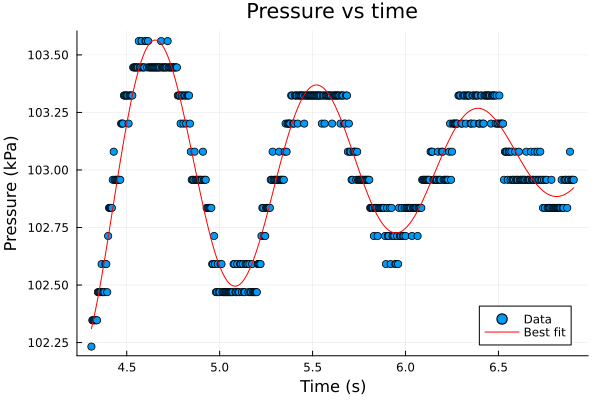

Parameters: [8.785168817030346, 0.5716806719814257, 7.251532356517116, -0.8243594500809708, -0.05126508877246121, 102.71301971182655]
Parameter errors (std dev): [0.8934034286639699, 0.019750376918694502, 0.019236642946374956, 0.0974215633300486, 0.004887035641081854, 0.027852046961513093]
Frequency error (%): 0.39 ± 0.66
Experimental γ: 1.389 ± 0.018
γ error (%): 0.79 ± 1.3


In [27]:
t15 = [4.31,	4.315,	4.32,	4.325,	4.33,	4.335,	4.34,	4.345,	4.35,	4.355,	4.36,	4.365,	4.37,	4.375,	4.38,	4.385,	4.39,	4.395,	4.4,	4.405,	4.41,	4.415,	4.42,	4.425,	4.43,	4.435,	4.44,	4.445,	4.45,	4.455,	4.46,	4.465,	4.47,	4.475,	4.48,	4.485,	4.49,	4.495,	4.5,	4.505,	4.51,	4.515,	4.52,	4.525,	4.53,	4.535,	4.54,	4.545,	4.55,	4.555,	4.56,	4.565,	4.57,	4.575,	4.58,	4.585,	4.59,	4.595,	4.6,	4.605,	4.61,	4.615,	4.62,	4.625,	4.63,	4.635,	4.64,	4.645,	4.65,	4.655,	4.66,	4.665,	4.67,	4.675,	4.68,	4.685,	4.69,	4.695,	4.7,	4.705,	4.71,	4.715,	4.72,	4.725,	4.73,	4.735,	4.74,	4.745,	4.75,	4.755,	4.76,	4.765,	4.77,	4.775,	4.78,	4.785,	4.79,	4.795,	4.8,	4.805,	4.81,	4.815,	4.82,	4.825,	4.83,	4.835,	4.84,	4.845,	4.85,	4.855,	4.86,	4.865,	4.87,	4.875,	4.88,	4.885,	4.89,	4.895,	4.9,	4.905,	4.91,	4.915,	4.92,	4.925,	4.93,	4.935,	4.94,	4.945,	4.95,	4.955,	4.96,	4.965,	4.97,	4.975,	4.98,	4.985,	4.99,	4.995,	5,	5.005,	5.01,	5.015,	5.02,	5.025,	5.03,	5.035,	5.04,	5.045,	5.05,	5.055,	5.06,	5.065,	5.07,	5.075,	5.08,	5.085,	5.09,	5.095,	5.1,	5.105,	5.11,	5.115,	5.12,	5.125,	5.13,	5.135,	5.14,	5.145,	5.15,	5.155,	5.16,	5.165,	5.17,	5.175,	5.18,	5.185,	5.19,	5.195,	5.2,	5.205,	5.21,	5.215,	5.22,	5.225,	5.23,	5.235,	5.24,	5.245,	5.25,	5.255,	5.26,	5.265,	5.27,	5.275,	5.28,	5.285,	5.29,	5.295,	5.3,	5.305,	5.31,	5.315,	5.32,	5.325,	5.33,	5.335,	5.34,	5.345,	5.35,	5.355,	5.36,	5.365,	5.37,	5.375,	5.38,	5.385,	5.39,	5.395,	5.4,	5.405,	5.41,	5.415,	5.42,	5.425,	5.43,	5.435,	5.44,	5.445,	5.45,	5.455,	5.46,	5.465,	5.47,	5.475,	5.48,	5.485,	5.49,	5.495,	5.5,	5.505,	5.51,	5.515,	5.52,	5.525,	5.53,	5.535,	5.54,	5.545,	5.55,	5.555,	5.56,	5.565,	5.57,	5.575,	5.58,	5.585,	5.59,	5.595,	5.6,	5.605,	5.61,	5.615,	5.62,	5.625,	5.63,	5.635,	5.64,	5.645,	5.65,	5.655,	5.66,	5.665,	5.67,	5.675,	5.68,	5.685,	5.69,	5.695,	5.7,	5.705,	5.71,	5.715,	5.72,	5.725,	5.73,	5.735,	5.74,	5.745,	5.75,	5.755,	5.76,	5.765,	5.77,	5.775,	5.78,	5.785,	5.79,	5.795,	5.8,	5.805,	5.81,	5.815,	5.82,	5.825,	5.83,	5.835,	5.84,	5.845,	5.85,	5.855,	5.86,	5.865,	5.87,	5.875,	5.88,	5.885,	5.89,	5.895,	5.9,	5.905,	5.91,	5.915,	5.92,	5.925,	5.93,	5.935,	5.94,	5.945,	5.95,	5.955,	5.96,	5.965,	5.97,	5.975,	5.98,	5.985,	5.99,	5.995,	6,	6.005,	6.01,	6.015,	6.02,	6.025,	6.03,	6.035,	6.04,	6.045,	6.05,	6.055,	6.06,	6.065,	6.07,	6.075,	6.08,	6.085,	6.09,	6.095,	6.1,	6.105,	6.11,	6.115,	6.12,	6.125,	6.13,	6.135,	6.14,	6.145,	6.15,	6.155,	6.16,	6.165,	6.17,	6.175,	6.18,	6.185,	6.19,	6.195,	6.2,	6.205,	6.21,	6.215,	6.22,	6.225,	6.23,	6.235,	6.24,	6.245,	6.25,	6.255,	6.26,	6.265,	6.27,	6.275,	6.28,	6.285,	6.29,	6.295,	6.3,	6.305,	6.31,	6.315,	6.32,	6.325,	6.33,	6.335,	6.34,	6.345,	6.35,	6.355,	6.36,	6.365,	6.37,	6.375,	6.38,	6.385,	6.39,	6.395,	6.4,	6.405,	6.41,	6.415,	6.42,	6.425,	6.43,	6.435,	6.44,	6.445,	6.45,	6.455,	6.46,	6.465,	6.47,	6.475,	6.48,	6.485,	6.49,	6.495,	6.5,	6.505,	6.51,	6.515,	6.52,	6.525,	6.53,	6.535,	6.54,	6.545,	6.55,	6.555,	6.56,	6.565,	6.57,	6.575,	6.58,	6.585,	6.59,	6.595,	6.6,	6.605,	6.61,	6.615,	6.62,	6.625,	6.63,	6.635,	6.64,	6.645,	6.65,	6.655,	6.66,	6.665,	6.67,	6.675,	6.68,	6.685,	6.69,	6.695,	6.7,	6.705,	6.71,	6.715,	6.72,	6.725,	6.73,	6.735,	6.74,	6.745,	6.75,	6.755,	6.76,	6.765,	6.77,	6.775,	6.78,	6.785,	6.79,	6.795,	6.8,	6.805,	6.81,	6.815,	6.82,	6.825,	6.83,	6.835,	6.84,	6.845,	6.85,	6.855,	6.86,	6.865,	6.87,	6.875,	6.88,	6.885,	6.89,	6.895,	6.9,	6.905]
p15 = [102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.560108184814,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.201526641845,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.079456329345,	103.201526641845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.591175079345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.591175079345,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.201526641845,	102.957386016845,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.835315704345,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845]

t = t15
p = p15

ωe, γe = analysis(t, p, V4, P4, model)

push!(ωs[5], ωe)
push!(γs[5], γe);

In [28]:
#New V and P
const V5 = (7023.8 ± 55)/1e6
const P5 = P4

push!(Vs, V5)
push!(Ps, P5)
push!(ωs, [])
push!(γs, []);

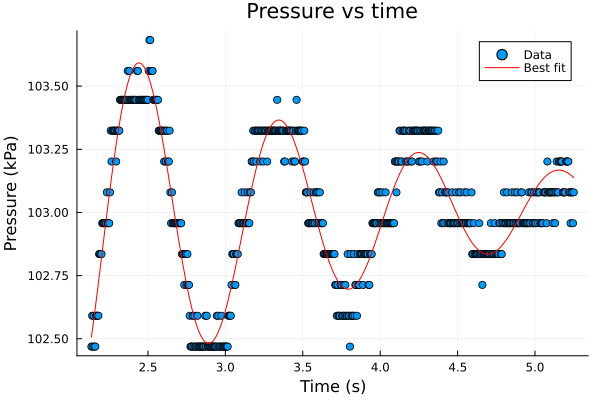

Parameters: [2.4395973446585844, 0.5531914880482268, 6.960605654965109, -2.9356327592198834, -0.02393859694917772, 102.90333771417545]
Parameter errors (std dev): [0.14507216937303977, 0.019098529408240375, 0.017819771635566167, 0.053000577911127375, 0.004194190720680056, 0.01606374245484904]
Frequency error (%): 0.79 ± 0.65
Experimental γ: 1.378 ± 0.018
γ error (%): 1.6 ± 1.3


In [29]:
t16 = [2.135,	2.14,	2.145,	2.15,	2.155,	2.16,	2.165,	2.17,	2.175,	2.18,	2.185,	2.19,	2.195,	2.2,	2.205,	2.21,	2.215,	2.22,	2.225,	2.23,	2.235,	2.24,	2.245,	2.25,	2.255,	2.26,	2.265,	2.27,	2.275,	2.28,	2.285,	2.29,	2.295,	2.3,	2.305,	2.31,	2.315,	2.32,	2.325,	2.33,	2.335,	2.34,	2.345,	2.35,	2.355,	2.36,	2.365,	2.37,	2.375,	2.38,	2.385,	2.39,	2.395,	2.4,	2.405,	2.41,	2.415,	2.42,	2.425,	2.43,	2.435,	2.44,	2.445,	2.45,	2.455,	2.46,	2.465,	2.47,	2.475,	2.48,	2.485,	2.49,	2.495,	2.5,	2.505,	2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54,	2.545,	2.55,	2.555,	2.56,	2.565,	2.57,	2.575,	2.58,	2.585,	2.59,	2.595,	2.6,	2.605,	2.61,	2.615,	2.62,	2.625,	2.63,	2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965,	2.97,	2.975,	2.98,	2.985,	2.99,	2.995,	3,	3.005,	3.01,	3.015,	3.02,	3.025,	3.03,	3.035,	3.04,	3.045,	3.05,	3.055,	3.06,	3.065,	3.07,	3.075,	3.08,	3.085,	3.09,	3.095,	3.1,	3.105,	3.11,	3.115,	3.12,	3.125,	3.13,	3.135,	3.14,	3.145,	3.15,	3.155,	3.16,	3.165,	3.17,	3.175,	3.18,	3.185,	3.19,	3.195,	3.2,	3.205,	3.21,	3.215,	3.22,	3.225,	3.23,	3.235,	3.24,	3.245,	3.25,	3.255,	3.26,	3.265,	3.27,	3.275,	3.28,	3.285,	3.29,	3.295,	3.3,	3.305,	3.31,	3.315,	3.32,	3.325,	3.33,	3.335,	3.34,	3.345,	3.35,	3.355,	3.36,	3.365,	3.37,	3.375,	3.38,	3.385,	3.39,	3.395,	3.4,	3.405,	3.41,	3.415,	3.42,	3.425,	3.43,	3.435,	3.44,	3.445,	3.45,	3.455,	3.46,	3.465,	3.47,	3.475,	3.48,	3.485,	3.49,	3.495,	3.5,	3.505,	3.51,	3.515,	3.52,	3.525,	3.53,	3.535,	3.54,	3.545,	3.55,	3.555,	3.56,	3.565,	3.57,	3.575,	3.58,	3.585,	3.59,	3.595,	3.6,	3.605,	3.61,	3.615,	3.62,	3.625,	3.63,	3.635,	3.64,	3.645,	3.65,	3.655,	3.66,	3.665,	3.67,	3.675,	3.68,	3.685,	3.69,	3.695,	3.7,	3.705,	3.71,	3.715,	3.72,	3.725,	3.73,	3.735,	3.74,	3.745,	3.75,	3.755,	3.76,	3.765,	3.77,	3.775,	3.78,	3.785,	3.79,	3.795,	3.8,	3.805,	3.81,	3.815,	3.82,	3.825,	3.83,	3.835,	3.84,	3.845,	3.85,	3.855,	3.86,	3.865,	3.87,	3.875,	3.88,	3.885,	3.89,	3.895,	3.9,	3.905,	3.91,	3.915,	3.92,	3.925,	3.93,	3.935,	3.94,	3.945,	3.95,	3.955,	3.96,	3.965,	3.97,	3.975,	3.98,	3.985,	3.99,	3.995,	4,	4.005,	4.01,	4.015,	4.02,	4.025,	4.03,	4.035,	4.04,	4.045,	4.05,	4.055,	4.06,	4.065,	4.07,	4.075,	4.08,	4.085,	4.09,	4.095,	4.1,	4.105,	4.11,	4.115,	4.12,	4.125,	4.13,	4.135,	4.14,	4.145,	4.15,	4.155,	4.16,	4.165,	4.17,	4.175,	4.18,	4.185,	4.19,	4.195,	4.2,	4.205,	4.21,	4.215,	4.22,	4.225,	4.23,	4.235,	4.24,	4.245,	4.25,	4.255,	4.26,	4.265,	4.27,	4.275,	4.28,	4.285,	4.29,	4.295,	4.3,	4.305,	4.31,	4.315,	4.32,	4.325,	4.33,	4.335,	4.34,	4.345,	4.35,	4.355,	4.36,	4.365,	4.37,	4.375,	4.38,	4.385,	4.39,	4.395,	4.4,	4.405,	4.41,	4.415,	4.42,	4.425,	4.43,	4.435,	4.44,	4.445,	4.45,	4.455,	4.46,	4.465,	4.47,	4.475,	4.48,	4.485,	4.49,	4.495,	4.5,	4.505,	4.51,	4.515,	4.52,	4.525,	4.53,	4.535,	4.54,	4.545,	4.55,	4.555,	4.56,	4.565,	4.57,	4.575,	4.58,	4.585,	4.59,	4.595,	4.6,	4.605,	4.61,	4.615,	4.62,	4.625,	4.63,	4.635,	4.64,	4.645,	4.65,	4.655,	4.66,	4.665,	4.67,	4.675,	4.68,	4.685,	4.69,	4.695,	4.7,	4.705,	4.71,	4.715,	4.72,	4.725,	4.73,	4.735,	4.74,	4.745,	4.75,	4.755,	4.76,	4.765,	4.77,	4.775,	4.78,	4.785,	4.79,	4.795,	4.8,	4.805,	4.81,	4.815,	4.82,	4.825,	4.83,	4.835,	4.84,	4.845,	4.85,	4.855,	4.86,	4.865,	4.87,	4.875,	4.88,	4.885,	4.89,	4.895,	4.9,	4.905,	4.91,	4.915,	4.92,	4.925,	4.93,	4.935,	4.94,	4.945,	4.95,	4.955,	4.96,	4.965,	4.97,	4.975,	4.98,	4.985,	4.99,	4.995,	5,	5.005,	5.01,	5.015,	5.02,	5.025,	5.03,	5.035,	5.04,	5.045,	5.05,	5.055,	5.06,	5.065,	5.07,	5.075,	5.08,	5.085,	5.09,	5.095,	5.1,	5.105,	5.11,	5.115,	5.12,	5.125,	5.13,	5.135,	5.14,	5.145,	5.15,	5.155,	5.16,	5.165,	5.17,	5.175,	5.18,	5.185,	5.19,	5.195,	5.2,	5.205,	5.21,	5.215,	5.22,	5.225,	5.23,	5.235,	5.24,	5.245,	5.25]
p16 = [102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.682178497314,	103.682178497314,	103.560108184814,	103.560108184814,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.445667266845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.835315704345,	102.591175079345,	102.591175079345,	102.469104766845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.835315704345,	102.591175079345,	102.713245391845,	102.713245391845,	102.591175079345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.201526641845,	103.201526641845,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.323596954345,	103.079456329345,	103.079456329345,	103.201526641845,	102.957386016845,	103.079456329345,	102.957386016845,	103.201526641845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.201526641845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.201526641845,	103.079456329345,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345]

t = t16
p = p16

ωe, γe = analysis(t, p, V5, P5, model)

push!(ωs[6], ωe)
push!(γs[6], γe);

In [30]:
const V6 = (7523.8 ± 60)/1e6
const P6 = P5

push!(Vs, V6)
push!(Ps, P6)
push!(ωs, [])
push!(γs, []);

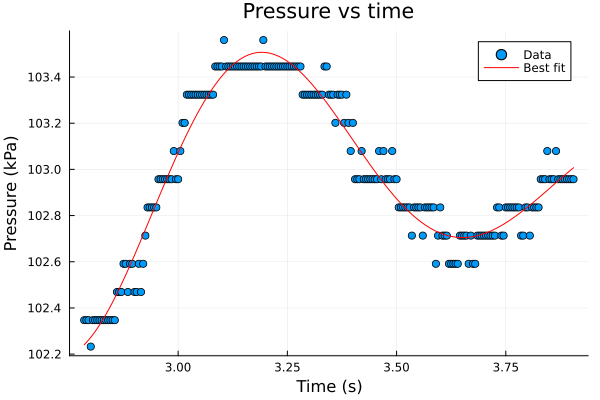

Parameters: [16.670241478957227, 1.096203280833755, 6.849201749732739, -1.5989902992370169, 0.007715948407010328, 103.03409644592229]
Parameter errors (std dev): [6.29417589389153, 0.12440326495153439, 0.1597425074726224, 0.5350423802338149, 0.07304863459945335, 0.25107200806404295]
Frequency error (%): 1.0 ± 4.7
Experimental γ: 1.43 ± 0.13
γ error (%): 2.1 ± 9.6


In [31]:
t17 = [2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965,	2.97,	2.975,	2.98,	2.985,	2.99,	2.995,	3,	3.005,	3.01,	3.015,	3.02,	3.025,	3.03,	3.035,	3.04,	3.045,	3.05,	3.055,	3.06,	3.065,	3.07,	3.075,	3.08,	3.085,	3.09,	3.095,	3.1,	3.105,	3.11,	3.115,	3.12,	3.125,	3.13,	3.135,	3.14,	3.145,	3.15,	3.155,	3.16,	3.165,	3.17,	3.175,	3.18,	3.185,	3.19,	3.195,	3.2,	3.205,	3.21,	3.215,	3.22,	3.225,	3.23,	3.235,	3.24,	3.245,	3.25,	3.255,	3.26,	3.265,	3.27,	3.275,	3.28,	3.285,	3.29,	3.295,	3.3,	3.305,	3.31,	3.315,	3.32,	3.325,	3.33,	3.335,	3.34,	3.345,	3.35,	3.355,	3.36,	3.365,	3.37,	3.375,	3.38,	3.385,	3.39,	3.395,	3.4,	3.405,	3.41,	3.415,	3.42,	3.425,	3.43,	3.435,	3.44,	3.445,	3.45,	3.455,	3.46,	3.465,	3.47,	3.475,	3.48,	3.485,	3.49,	3.495,	3.5,	3.505,	3.51,	3.515,	3.52,	3.525,	3.53,	3.535,	3.54,	3.545,	3.55,	3.555,	3.56,	3.565,	3.57,	3.575,	3.58,	3.585,	3.59,	3.595,	3.6,	3.605,	3.61,	3.615,	3.62,	3.625,	3.63,	3.635,	3.64,	3.645,	3.65,	3.655,	3.66,	3.665,	3.67,	3.675,	3.68,	3.685,	3.69,	3.695,	3.7,	3.705,	3.71,	3.715,	3.72,	3.725,	3.73,	3.735,	3.74,	3.745,	3.75,	3.755,	3.76,	3.765,	3.77,	3.775,	3.78,	3.785,	3.79,	3.795,	3.8,	3.805,	3.81,	3.815,	3.82,	3.825,	3.83,	3.835,	3.84,	3.845,	3.85,	3.855,	3.86,	3.865,	3.87,	3.875,	3.88,	3.885,	3.89,	3.895,	3.9,	3.905]
p17 = [102.347034454345,	102.347034454345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.445667266845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.079456329345,	103.201526641845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.713245391845,	102.835315704345,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845]

t = t17
p = p17

ωe, γe = analysis(t, p, V6, P6, model)

push!(ωs[7], ωe)
push!(γs[7], γe);

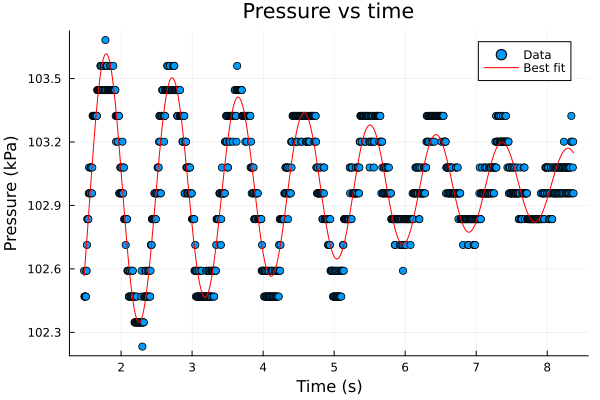

Parameters: [-0.9863771195706281, 0.216721162915027, 6.764859069446997, -1.142965785138986, -0.009086160650700687, 102.93193668098097]
Parameter errors (std dev): [0.020603889596557373, 0.005407658865248087, 0.005236460694586773, 0.019543715041250152, 0.0012571895656866285, 0.0066864922603416185]
Frequency error (%): 0.21 ± 0.44
Experimental γ: 1.394 ± 0.012
γ error (%): 0.42 ± 0.87


In [32]:
t18 = [1.48,	1.485,	1.49,	1.495,	1.5,	1.505,	1.51,	1.515,	1.52,	1.525,	1.53,	1.535,	1.54,	1.545,	1.55,	1.555,	1.56,	1.565,	1.57,	1.575,	1.58,	1.585,	1.59,	1.595,	1.6,	1.605,	1.61,	1.615,	1.62,	1.625,	1.63,	1.635,	1.64,	1.645,	1.65,	1.655,	1.66,	1.665,	1.67,	1.675,	1.68,	1.685,	1.69,	1.695,	1.7,	1.705,	1.71,	1.715,	1.72,	1.725,	1.73,	1.735,	1.74,	1.745,	1.75,	1.755,	1.76,	1.765,	1.77,	1.775,	1.78,	1.785,	1.79,	1.795,	1.8,	1.805,	1.81,	1.815,	1.82,	1.825,	1.83,	1.835,	1.84,	1.845,	1.85,	1.855,	1.86,	1.865,	1.87,	1.875,	1.88,	1.885,	1.89,	1.895,	1.9,	1.905,	1.91,	1.915,	1.92,	1.925,	1.93,	1.935,	1.94,	1.945,	1.95,	1.955,	1.96,	1.965,	1.97,	1.975,	1.98,	1.985,	1.99,	1.995,	2,	2.005,	2.01,	2.015,	2.02,	2.025,	2.03,	2.035,	2.04,	2.045,	2.05,	2.055,	2.06,	2.065,	2.07,	2.075,	2.08,	2.085,	2.09,	2.095,	2.1,	2.105,	2.11,	2.115,	2.12,	2.125,	2.13,	2.135,	2.14,	2.145,	2.15,	2.155,	2.16,	2.165,	2.17,	2.175,	2.18,	2.185,	2.19,	2.195,	2.2,	2.205,	2.21,	2.215,	2.22,	2.225,	2.23,	2.235,	2.24,	2.245,	2.25,	2.255,	2.26,	2.265,	2.27,	2.275,	2.28,	2.285,	2.29,	2.295,	2.3,	2.305,	2.31,	2.315,	2.32,	2.325,	2.33,	2.335,	2.34,	2.345,	2.35,	2.355,	2.36,	2.365,	2.37,	2.375,	2.38,	2.385,	2.39,	2.395,	2.4,	2.405,	2.41,	2.415,	2.42,	2.425,	2.43,	2.435,	2.44,	2.445,	2.45,	2.455,	2.46,	2.465,	2.47,	2.475,	2.48,	2.485,	2.49,	2.495,	2.5,	2.505,	2.51,	2.515,	2.52,	2.525,	2.53,	2.535,	2.54,	2.545,	2.55,	2.555,	2.56,	2.565,	2.57,	2.575,	2.58,	2.585,	2.59,	2.595,	2.6,	2.605,	2.61,	2.615,	2.62,	2.625,	2.63,	2.635,	2.64,	2.645,	2.65,	2.655,	2.66,	2.665,	2.67,	2.675,	2.68,	2.685,	2.69,	2.695,	2.7,	2.705,	2.71,	2.715,	2.72,	2.725,	2.73,	2.735,	2.74,	2.745,	2.75,	2.755,	2.76,	2.765,	2.77,	2.775,	2.78,	2.785,	2.79,	2.795,	2.8,	2.805,	2.81,	2.815,	2.82,	2.825,	2.83,	2.835,	2.84,	2.845,	2.85,	2.855,	2.86,	2.865,	2.87,	2.875,	2.88,	2.885,	2.89,	2.895,	2.9,	2.905,	2.91,	2.915,	2.92,	2.925,	2.93,	2.935,	2.94,	2.945,	2.95,	2.955,	2.96,	2.965,	2.97,	2.975,	2.98,	2.985,	2.99,	2.995,	3,	3.005,	3.01,	3.015,	3.02,	3.025,	3.03,	3.035,	3.04,	3.045,	3.05,	3.055,	3.06,	3.065,	3.07,	3.075,	3.08,	3.085,	3.09,	3.095,	3.1,	3.105,	3.11,	3.115,	3.12,	3.125,	3.13,	3.135,	3.14,	3.145,	3.15,	3.155,	3.16,	3.165,	3.17,	3.175,	3.18,	3.185,	3.19,	3.195,	3.2,	3.205,	3.21,	3.215,	3.22,	3.225,	3.23,	3.235,	3.24,	3.245,	3.25,	3.255,	3.26,	3.265,	3.27,	3.275,	3.28,	3.285,	3.29,	3.295,	3.3,	3.305,	3.31,	3.315,	3.32,	3.325,	3.33,	3.335,	3.34,	3.345,	3.35,	3.355,	3.36,	3.365,	3.37,	3.375,	3.38,	3.385,	3.39,	3.395,	3.4,	3.405,	3.41,	3.415,	3.42,	3.425,	3.43,	3.435,	3.44,	3.445,	3.45,	3.455,	3.46,	3.465,	3.47,	3.475,	3.48,	3.485,	3.49,	3.495,	3.5,	3.505,	3.51,	3.515,	3.52,	3.525,	3.53,	3.535,	3.54,	3.545,	3.55,	3.555,	3.56,	3.565,	3.57,	3.575,	3.58,	3.585,	3.59,	3.595,	3.6,	3.605,	3.61,	3.615,	3.62,	3.625,	3.63,	3.635,	3.64,	3.645,	3.65,	3.655,	3.66,	3.665,	3.67,	3.675,	3.68,	3.685,	3.69,	3.695,	3.7,	3.705,	3.71,	3.715,	3.72,	3.725,	3.73,	3.735,	3.74,	3.745,	3.75,	3.755,	3.76,	3.765,	3.77,	3.775,	3.78,	3.785,	3.79,	3.795,	3.8,	3.805,	3.81,	3.815,	3.82,	3.825,	3.83,	3.835,	3.84,	3.845,	3.85,	3.855,	3.86,	3.865,	3.87,	3.875,	3.88,	3.885,	3.89,	3.895,	3.9,	3.905,	3.91,	3.915,	3.92,	3.925,	3.93,	3.935,	3.94,	3.945,	3.95,	3.955,	3.96,	3.965,	3.97,	3.975,	3.98,	3.985,	3.99,	3.995,	4,	4.005,	4.01,	4.015,	4.02,	4.025,	4.03,	4.035,	4.04,	4.045,	4.05,	4.055,	4.06,	4.065,	4.07,	4.075,	4.08,	4.085,	4.09,	4.095,	4.1,	4.105,	4.11,	4.115,	4.12,	4.125,	4.13,	4.135,	4.14,	4.145,	4.15,	4.155,	4.16,	4.165,	4.17,	4.175,	4.18,	4.185,	4.19,	4.195,	4.2,	4.205,	4.21,	4.215,	4.22,	4.225,	4.23,	4.235,	4.24,	4.245,	4.25,	4.255,	4.26,	4.265,	4.27,	4.275,	4.28,	4.285,	4.29,	4.295,	4.3,	4.305,	4.31,	4.315,	4.32,	4.325,	4.33,	4.335,	4.34,	4.345,	4.35,	4.355,	4.36,	4.365,	4.37,	4.375,	4.38,	4.385,	4.39,	4.395,	4.4,	4.405,	4.41,	4.415,	4.42,	4.425,	4.43,	4.435,	4.44,	4.445,	4.45,	4.455,	4.46,	4.465,	4.47,	4.475,	4.48,	4.485,	4.49,	4.495,	4.5,	4.505,	4.51,	4.515,	4.52,	4.525,	4.53,	4.535,	4.54,	4.545,	4.55,	4.555,	4.56,	4.565,	4.57,	4.575,	4.58,	4.585,	4.59,	4.595,	4.6,	4.605,	4.61,	4.615,	4.62,	4.625,	4.63,	4.635,	4.64,	4.645,	4.65,	4.655,	4.66,	4.665,	4.67,	4.675,	4.68,	4.685,	4.69,	4.695,	4.7,	4.705,	4.71,	4.715,	4.72,	4.725,	4.73,	4.735,	4.74,	4.745,	4.75,	4.755,	4.76,	4.765,	4.77,	4.775,	4.78,	4.785,	4.79,	4.795,	4.8,	4.805,	4.81,	4.815,	4.82,	4.825,	4.83,	4.835,	4.84,	4.845,	4.85,	4.855,	4.86,	4.865,	4.87,	4.875,	4.88,	4.885,	4.89,	4.895,	4.9,	4.905,	4.91,	4.915,	4.92,	4.925,	4.93,	4.935,	4.94,	4.945,	4.95,	4.955,	4.96,	4.965,	4.97,	4.975,	4.98,	4.985,	4.99,	4.995,	5,	5.005,	5.01,	5.015,	5.02,	5.025,	5.03,	5.035,	5.04,	5.045,	5.05,	5.055,	5.06,	5.065,	5.07,	5.075,	5.08,	5.085,	5.09,	5.095,	5.1,	5.105,	5.11,	5.115,	5.12,	5.125,	5.13,	5.135,	5.14,	5.145,	5.15,	5.155,	5.16,	5.165,	5.17,	5.175,	5.18,	5.185,	5.19,	5.195,	5.2,	5.205,	5.21,	5.215,	5.22,	5.225,	5.23,	5.235,	5.24,	5.245,	5.25,	5.255,	5.26,	5.265,	5.27,	5.275,	5.28,	5.285,	5.29,	5.295,	5.3,	5.305,	5.31,	5.315,	5.32,	5.325,	5.33,	5.335,	5.34,	5.345,	5.35,	5.355,	5.36,	5.365,	5.37,	5.375,	5.38,	5.385,	5.39,	5.395,	5.4,	5.405,	5.41,	5.415,	5.42,	5.425,	5.43,	5.435,	5.44,	5.445,	5.45,	5.455,	5.46,	5.465,	5.47,	5.475,	5.48,	5.485,	5.49,	5.495,	5.5,	5.505,	5.51,	5.515,	5.52,	5.525,	5.53,	5.535,	5.54,	5.545,	5.55,	5.555,	5.56,	5.565,	5.57,	5.575,	5.58,	5.585,	5.59,	5.595,	5.6,	5.605,	5.61,	5.615,	5.62,	5.625,	5.63,	5.635,	5.64,	5.645,	5.65,	5.655,	5.66,	5.665,	5.67,	5.675,	5.68,	5.685,	5.69,	5.695,	5.7,	5.705,	5.71,	5.715,	5.72,	5.725,	5.73,	5.735,	5.74,	5.745,	5.75,	5.755,	5.76,	5.765,	5.77,	5.775,	5.78,	5.785,	5.79,	5.795,	5.8,	5.805,	5.81,	5.815,	5.82,	5.825,	5.83,	5.835,	5.84,	5.845,	5.85,	5.855,	5.86,	5.865,	5.87,	5.875,	5.88,	5.885,	5.89,	5.895,	5.9,	5.905,	5.91,	5.915,	5.92,	5.925,	5.93,	5.935,	5.94,	5.945,	5.95,	5.955,	5.96,	5.965,	5.97,	5.975,	5.98,	5.985,	5.99,	5.995,	6,	6.005,	6.01,	6.015,	6.02,	6.025,	6.03,	6.035,	6.04,	6.045,	6.05,	6.055,	6.06,	6.065,	6.07,	6.075,	6.08,	6.085,	6.09,	6.095,	6.1,	6.105,	6.11,	6.115,	6.12,	6.125,	6.13,	6.135,	6.14,	6.145,	6.15,	6.155,	6.16,	6.165,	6.17,	6.175,	6.18,	6.185,	6.19,	6.195,	6.2,	6.205,	6.21,	6.215,	6.22,	6.225,	6.23,	6.235,	6.24,	6.245,	6.25,	6.255,	6.26,	6.265,	6.27,	6.275,	6.28,	6.285,	6.29,	6.295,	6.3,	6.305,	6.31,	6.315,	6.32,	6.325,	6.33,	6.335,	6.34,	6.345,	6.35,	6.355,	6.36,	6.365,	6.37,	6.375,	6.38,	6.385,	6.39,	6.395,	6.4,	6.405,	6.41,	6.415,	6.42,	6.425,	6.43,	6.435,	6.44,	6.445,	6.45,	6.455,	6.46,	6.465,	6.47,	6.475,	6.48,	6.485,	6.49,	6.495,	6.5,	6.505,	6.51,	6.515,	6.52,	6.525,	6.53,	6.535,	6.54,	6.545,	6.55,	6.555,	6.56,	6.565,	6.57,	6.575,	6.58,	6.585,	6.59,	6.595,	6.6,	6.605,	6.61,	6.615,	6.62,	6.625,	6.63,	6.635,	6.64,	6.645,	6.65,	6.655,	6.66,	6.665,	6.67,	6.675,	6.68,	6.685,	6.69,	6.695,	6.7,	6.705,	6.71,	6.715,	6.72,	6.725,	6.73,	6.735,	6.74,	6.745,	6.75,	6.755,	6.76,	6.765,	6.77,	6.775,	6.78,	6.785,	6.79,	6.795,	6.8,	6.805,	6.81,	6.815,	6.82,	6.825,	6.83,	6.835,	6.84,	6.845,	6.85,	6.855,	6.86,	6.865,	6.87,	6.875,	6.88,	6.885,	6.89,	6.895,	6.9,	6.905,	6.91,	6.915,	6.92,	6.925,	6.93,	6.935,	6.94,	6.945,	6.95,	6.955,	6.96,	6.965,	6.97,	6.975,	6.98,	6.985,	6.99,	6.995,	7,	7.005,	7.01,	7.015,	7.02,	7.025,	7.03,	7.035,	7.04,	7.045,	7.05,	7.055,	7.06,	7.065,	7.07,	7.075,	7.08,	7.085,	7.09,	7.095,	7.1,	7.105,	7.11,	7.115,	7.12,	7.125,	7.13,	7.135,	7.14,	7.145,	7.15,	7.155,	7.16,	7.165,	7.17,	7.175,	7.18,	7.185,	7.19,	7.195,	7.2,	7.205,	7.21,	7.215,	7.22,	7.225,	7.23,	7.235,	7.24,	7.245,	7.25,	7.255,	7.26,	7.265,	7.27,	7.275,	7.28,	7.285,	7.29,	7.295,	7.3,	7.305,	7.31,	7.315,	7.32,	7.325,	7.33,	7.335,	7.34,	7.345,	7.35,	7.355,	7.36,	7.365,	7.37,	7.375,	7.38,	7.385,	7.39,	7.395,	7.4,	7.405,	7.41,	7.415,	7.42,	7.425,	7.43,	7.435,	7.44,	7.445,	7.45,	7.455,	7.46,	7.465,	7.47,	7.475,	7.48,	7.485,	7.49,	7.495,	7.5,	7.505,	7.51,	7.515,	7.52,	7.525,	7.53,	7.535,	7.54,	7.545,	7.55,	7.555,	7.56,	7.565,	7.57,	7.575,	7.58,	7.585,	7.59,	7.595,	7.6,	7.605,	7.61,	7.615,	7.62,	7.625,	7.63,	7.635,	7.64,	7.645,	7.65,	7.655,	7.66,	7.665,	7.67,	7.675,	7.68,	7.685,	7.69,	7.695,	7.7,	7.705,	7.71,	7.715,	7.72,	7.725,	7.73,	7.735,	7.74,	7.745,	7.75,	7.755,	7.76,	7.765,	7.77,	7.775,	7.78,	7.785,	7.79,	7.795,	7.8,	7.805,	7.81,	7.815,	7.82,	7.825,	7.83,	7.835,	7.84,	7.845,	7.85,	7.855,	7.86,	7.865,	7.87,	7.875,	7.88,	7.885,	7.89,	7.895,	7.9,	7.905,	7.91,	7.915,	7.92,	7.925,	7.93,	7.935,	7.94,	7.945,	7.95,	7.955,	7.96,	7.965,	7.97,	7.975,	7.98,	7.985,	7.99,	7.995,	8,	8.005,	8.01,	8.015,	8.02,	8.025,	8.03,	8.035,	8.04,	8.045,	8.05,	8.055,	8.06,	8.065,	8.07,	8.075,	8.08,	8.085,	8.09,	8.095,	8.1,	8.105,	8.11,	8.115,	8.12,	8.125,	8.13,	8.135,	8.14,	8.145,	8.15,	8.155,	8.16,	8.165,	8.17,	8.175,	8.18,	8.185,	8.19,	8.195,	8.2,	8.205,	8.21,	8.215,	8.22,	8.225,	8.23,	8.235,	8.24,	8.245,	8.25,	8.255,	8.26,	8.265,	8.27,	8.275,	8.28,	8.285,	8.29,	8.295,	8.3,	8.305,	8.31,	8.315,	8.32,	8.325,	8.33,	8.335,	8.34,	8.345,	8.35,	8.355,	8.36,	8.365,	8.37]
p18 = [102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.682178497314,	103.560108184814,	103.445667266845,	103.560108184814,	103.560108184814,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.201526641845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.591175079345,	102.347034454345,	102.232593536377,	102.347034454345,	102.347034454345,	102.347034454345,	102.347034454345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.713245391845,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	102.957386016845,	102.957386016845,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.445667266845,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.560108184814,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.323596954345,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.445667266845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	102.957386016845,	102.957386016845,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.591175079345,	102.713245391845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.713245391845,	102.835315704345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.079456329345,	103.079456329345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.445667266845,	103.323596954345,	103.445667266845,	103.323596954345,	103.323596954345,	103.201526641845,	103.445667266845,	103.560108184814,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.445667266845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.079456329345,	103.201526641845,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.591175079345,	102.713245391845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.591175079345,	102.469104766845,	102.713245391845,	102.591175079345,	102.835315704345,	102.591175079345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.201526641845,	103.079456329345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.201526641845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.469104766845,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.469104766845,	102.591175079345,	102.591175079345,	102.591175079345,	102.591175079345,	102.713245391845,	102.713245391845,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	103.079456329345,	102.957386016845,	103.079456329345,	102.835315704345,	102.835315704345,	102.835315704345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.079456329345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.079456329345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	102.957386016845,	103.201526641845,	103.201526641845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.591175079345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.835315704345,	102.835315704345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.713245391845,	102.713245391845,	102.835315704345,	102.835315704345,	102.713245391845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	103.079456329345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.201526641845,	103.079456329345,	103.323596954345,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.323596954345,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.323596954345,	103.201526641845,	103.201526641845,	103.201526641845,	103.079456329345,	103.201526641845,	103.201526641845,	103.201526641845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	102.957386016845,	102.957386016845,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.835315704345,	102.835315704345,	102.835315704345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	103.079456329345,	103.201526641845,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	102.957386016845,	102.957386016845,	103.079456329345,	102.957386016845,	103.079456329345,	103.079456329345,	103.079456329345,	102.957386016845,	103.201526641845,	103.323596954345,	103.201526641845,	102.957386016845,	102.957386016845,	103.079456329345,	103.201526641845,	102.957386016845]

t = t18
p = p18

ωe, γe = analysis(t, p, V6, P6, model, predictions=[-1, 0.1, sqrt(1.4*P6*(A^2)/(m*V6)).val, -π/2, 0.005, P6.val/1000])

push!(ωs[7], ωe)
push!(γs[7], γe);

### Results

In the following cells, we analyze the results of the data analysis above.

In [33]:
allγs = [e for v in γs for e in v];

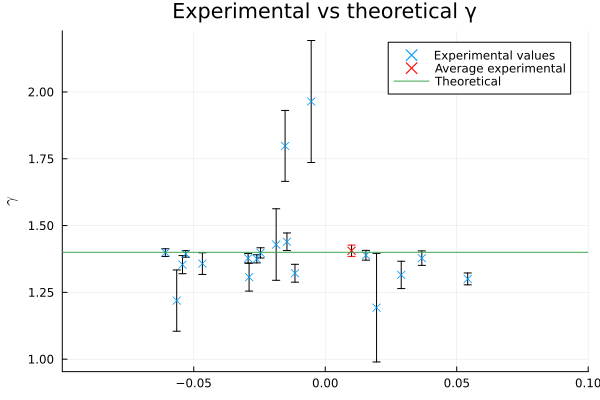

Averaged γ error (%): 0.42 ± 1.5


In [54]:
z = zeros(length(allγs))
for i in 1:length(z)
  z[i] = (rand()-0.5)/8
end
plt = plot(scatter(z, allγs, markershape=:x, label="Experimental values", xlimits=[-0.1, 0.1]))
γave = sum(allγs)/length(allγs)
plt = plot!(scatter!([0.01], [γave], label="Average experimental", markershape=:x, markercolor=:red), xlimits=[-0.1, 0.1])
#plt = hline!([γave], label="Average experimental")
plt = hline!([1.4], label="Theoretical")
plt = ylabel!("\$ γ \$")
plt = title!("Experimental vs theoretical γ")
display(plt)
println("Averaged γ error (%): "*string(abs(γave - γ)/γ*100))

This next cell averages the results for the angular frequencies for each volume.

In [35]:
ωaves = [
    sum(ωs[1])/length(ωs[1]),
    sum(ωs[2])/length(ωs[2]),
    sum(ωs[3])/length(ωs[3]),
    sum(ωs[4])/length(ωs[4]),
    sum(ωs[5])/length(ωs[5]),
    sum(ωs[6])/length(ωs[6]),
    sum(ωs[7])/length(ωs[7])
]
Ts = 2*π./ωaves
Tsquareds = Any[]
Tsquareds = Ts.^2;

By equation 2, we would expect a linear relationship between $T^2$ and $V$. In this next cell, we apply a linear model (with y-intercept at 0) to our data.

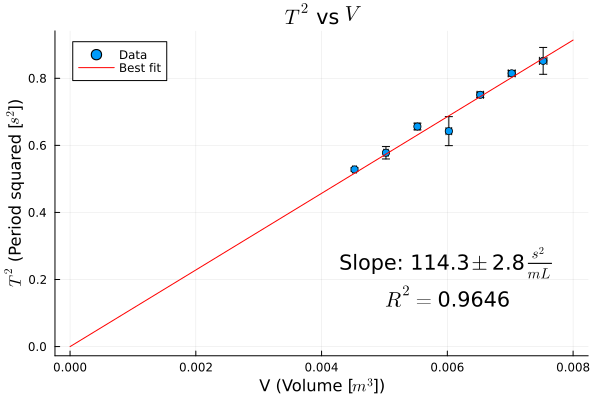

In [44]:
TsquaredvsVmodel(x, p) = p[1]*x

fit = curve_fit(TsquaredvsVmodel, [e.val for e in Vs], [e.val for e in Tsquareds], [1.0])

M = coef(fit)
σ = stderror(fit)
bestfit(x) = M[1]*x

SStot = sum((Tsquareds.-mean(Tsquareds)).^2)
SSres = sum((Tsquareds.-bestfit.(Vs)).^2)
Rsq = 1-SSres/SStot

plt = plot(scatter([e for e in Vs], [e for e in Tsquareds], label="Data"))
plt = plot!([0.0, 0.008], bestfit.([0.0, 0.008]), color="red", label="Best fit")
plt = xlabel!(plt, "V (Volume [\$m^3\$])")
plt = ylabel!(plt, "\$ T^2 \$ (Period squared [\$ s^2 \$])")
plt = title!(plt, "\$T^2\$ vs \$V\$")

plt = annotate!(
  0.006,
  0.15,
  latexstring("\$R^2 = \$"*string(round(Rsq.val, digits=4)))
)
plt = annotate!(
  0.006,
  0.25,
  latexstring("Slope: "*string(round(M[1], digits=1))*L"\; ±\;"*string(round(2*σ[1], digits=1))*L"\dfrac{s^2}{mL}")
)

display(plt)

In the above cell, we include the origin. But in the cell below, it is zoomed into the data.

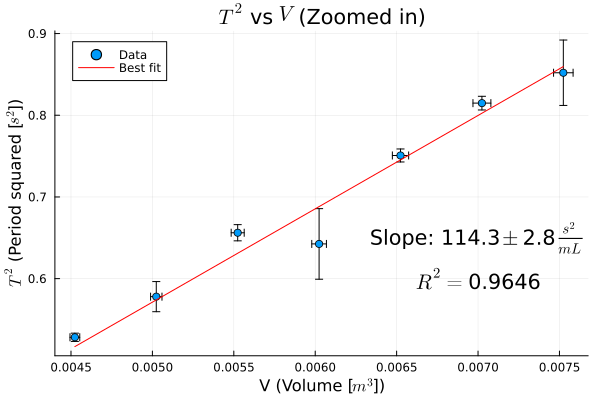

In [43]:
TsquaredvsVmodel(x, p) = p[1]*x

fit = curve_fit(TsquaredvsVmodel, [e.val for e in Vs], [e.val for e in Tsquareds], [1.0])

M = coef(fit)
σ = stderror(fit)
bestfit(x) = M[1]*x

SStot = sum((Tsquareds.-mean(Tsquareds)).^2)
SSres = sum((Tsquareds.-bestfit.(Vs)).^2)
Rsq = 1-SSres/SStot

plt = plot(scatter([e for e in Vs], [e for e in Tsquareds], label="Data"))
plt = plot!([e.val for e in Vs], bestfit.([e.val for e in Vs]), color="red", label="Best fit")
plt = xlabel!(plt, "V (Volume [\$m^3\$])")
plt = ylabel!(plt, "\$ T^2 \$ (Period squared [\$ s^2 \$])")
plt = title!(plt, "\$T^2\$ vs \$V\$ (Zoomed in)")

plt = annotate!(
  0.007,
  0.6,
  latexstring("\$R^2 = \$"*string(round(Rsq.val, digits=4)))
)
plt = annotate!(
  0.007,
  0.65,
  latexstring("Slope: "*string(round(M[1], digits=1))*L"\; ±\;"*string(round(2*σ[1], digits=1))*L"\dfrac{s^2}{mL}")
)

display(plt)

For comparison, here is our theoretical slope of the line of $T^2$ vs $V$:

In [38]:
Mtheo = 4*π^2*m/(γ*(sum(Ps)/length(Ps))*A^2)

114.45 ± 0.12

And here is our experimental value for $\gamma$ from all of our data:

In [39]:
γₑ = (1/(M[1] ± 2*σ[1]))*4*π^2*m/(sum(Ps)/length(Ps)*A^2)

1.402 ± 0.035

This next calculation is the relative uncertainty (%) of this experimental value:

In [40]:
#Relative uncertainty %
γₑ.err/γₑ.val*100

2.466667924120777

And here is our error between our experimental and theoretical values:

In [57]:
#Error %
round((abs(γₑ - γ)/γ*100).val, digits=2)

0.18